<a href="https://colab.research.google.com/github/Tetpoptet/Step_project_IKEA1/blob/main/%22Step_Project_IKEA%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, zscore
from scipy.stats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon, ranksums, kruskal
from sklearn.utils import resample
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import f_oneway

'''Project 2'''
data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/""tidytuesday/master/data/2020/2020-11-03/ikea.csv")
data = data.rename(columns={'Unnamed: 0': 'index'})

In [10]:
# Find duplicate
# 1) Elimination of duplicates by 'item_id'
unique_data = data.drop_duplicates(subset=['item_id'], keep='first').copy()

In [11]:
# 2) Find duplicate by 'designer'

# Замінюємо значення поля 'designer' на оброблені рядки
unique_data['designer'] = unique_data['designer'].apply(lambda x: "/".join(sorted(x.split("/"))))

# Створюємо словник, де ключ - це відсортоване значення 'designer', а значення - індекси рядків з такими значеннями
designer_indices = defaultdict(list)
for i, designer in enumerate(unique_data['designer']):
    sorted_designer = "/".join(sorted(designer.split("/")))
    designer_indices[sorted_designer].append(i)

# Знаходимо індекси рядків, які мають дублікати в оброблених значеннях 'designer'
duplicate_indices = [indices for indices in designer_indices.values() if len(indices) > 1]

# Виділяємо рядки з дублікатами на основі індексів та скидаємо індекси
designer_duplicates_data = unique_data.iloc[np.concatenate(duplicate_indices)].reset_index(drop=True)
print(designer_duplicates_data)



      index   item_id            name              category   price  \
0         0  90420332        FREKVENS         Bar furniture   265.0   
1        13  50420329        FREKVENS         Bar furniture   177.0   
2       846  10251451         IKEA PS  Cabinets & cupboards   425.0   
3      1226  39207716           JULES                Chairs   255.0   
4      2110  99335985        FREKVENS     Outdoor furniture   619.0   
...     ...       ...             ...                   ...     ...   
2799   3599   9325047  PAX / TYSSEDAL             Wardrobes  6805.0   
2800   3615  89243929             PAX             Wardrobes  3885.0   
2801   3649  19306307             PAX             Wardrobes  3885.0   
2802   3664  89243335             PAX             Wardrobes  3115.0   
2803   3668  29306302             PAX             Wardrobes  3115.0   

         old_price  sellable_online  \
0     No old price             True   
1           SR 295             True   
2     No old price            

In [12]:
# 3) Find duplicate by  'designer' and 'depth', 'height', 'width'
same_dims_data = []
for i, row in designer_duplicates_data.iterrows():dims = sorted([float(x) if isinstance(x, str) and not pd.isna(x)
else x for x in [row['depth'], row['height'], row['width']]])
key = tuple(dims)
row['dims'] = str(key)
row['link'] = re.sub(r'\d+', '', row['link'])
same_dims_data.append(row)
same_dims_data = pd.DataFrame(same_dims_data)
same_dims_data = same_dims_data[same_dims_data['dims'].duplicated(keep=False)]
print (same_dims_data)


Empty DataFrame
Columns: [index, item_id, name, category, price, old_price, sellable_online, link, other_colors, short_description, designer, depth, height, width, dims]
Index: []


In [13]:

# Initialize an empty list to store rows with the same dimensions
same_dims_data = []

# Iterate through rows in the designer_duplicates_data DataFrame
for i, row in designer_duplicates_data.iterrows():
    # Convert dimensions to sorted list of floats, handling NaN values
    dims = sorted([float(x) if isinstance(x, str) and not pd.isna(x) else x for x in [row['depth'], row['height'], row['width']]])

    # Create a tuple of dimensions as a key
    key = tuple(dims)

    # Modify the 'link' column to remove numbers
    row['link'] = re.sub(r'\d+', '', row['link'])

    # Add dimensions and modified 'link' to the row
    row['dims'] = str(key)

    # Append the row to the list
    same_dims_data.append(row)

# Create a DataFrame from the list of rows with the same dimensions
same_dims_data = pd.DataFrame(same_dims_data)

# Keep rows with duplicated dimensions
same_dims_data = same_dims_data[same_dims_data['dims'].duplicated(keep=False)]

# Print the DataFrame with rows having duplicated dimensions
print(same_dims_data)


      index   item_id                   name                    category  \
4      2110  99335985               FREKVENS           Outdoor furniture   
6         1    368814              NORDVIKEN               Bar furniture   
7         2   9333523  NORDVIKEN / NORDVIKEN               Bar furniture   
11      345  29276531                  ALGOT  Bookcases & shelving units   
12      346  40347886                EDVALLA  Bookcases & shelving units   
...     ...       ...                    ...                         ...   
2799   3599   9325047         PAX / TYSSEDAL                   Wardrobes   
2800   3615  89243929                    PAX                   Wardrobes   
2801   3649  19306307                    PAX                   Wardrobes   
2802   3664  89243335                    PAX                   Wardrobes   
2803   3668  29306302                    PAX                   Wardrobes   

       price     old_price  sellable_online  \
4      619.0        SR 855             T

In [14]:
# 4) Find duplicates by 'depth', 'height', 'width' and 'name', 'price', 'old_price','designer'
# Group the data based on specified columns and filter groups with more than one entry
grouped_data = same_dims_data.groupby(['name', 'price', 'old_price', 'designer']).filter(lambda x: len(x) > 1)
print (grouped_data)

      index   item_id              name                    category   price  \
12      346  40347886           EDVALLA  Bookcases & shelving units    25.0   
20      450    347888           EDVALLA  Bookcases & shelving units    25.0   
21      453  20218545             ALGOT  Bookcases & shelving units     9.0   
22      472  40347508           ENERYDA  Bookcases & shelving units    22.0   
23      480  10434187             ALGOT  Bookcases & shelving units     9.0   
...     ...       ...               ...                         ...     ...   
2760   3176   9330874  HILVER / LERBERG              Tables & desks   435.0   
2800   3615  89243929               PAX                   Wardrobes  3885.0   
2801   3649  19306307               PAX                   Wardrobes  3885.0   
2802   3664  89243335               PAX                   Wardrobes  3115.0   
2803   3668  29306302               PAX                   Wardrobes  3115.0   

         old_price  sellable_online  \
12    No old

In [15]:
# 5) Find duplicate by 'name', 'price', 'old_price', 'designer', 'depth', 'height','width' и 'short_description'
# Filter out rows with 'short_description' containing digits
description_duplicates = grouped_data[grouped_data['short_description'].str.contains(r'\d+')]

# Create a copy of the filtered data and process 'short_description' values
description_duplicates = description_duplicates.copy()
description_duplicates['short_description'] = description_duplicates['short_description'].apply(
    lambda x: "/".join(sorted(re.findall(r'\d+', x)))
)

# Group the data based on specified columns and filter groups with more than one entry
description_duplicates = description_duplicates.groupby(
    ['name', 'price', 'old_price', 'designer', 'short_description']
).filter(lambda x: len(x) > 1)

# Filter out rows where 'short_description' doesn't contain digits
non_description_duplicates = grouped_data[grouped_data['short_description'].str.contains(r'\d+') == False]

# Group the data based on specified columns and filter groups with more than one entry
project_3_duplicates = non_description_duplicates.groupby(
    ['name', 'price', 'old_price', 'designer']
).filter(lambda x: len(x) > 1)

# Combine the two filtered DataFrames
description_duplicates = pd.concat([description_duplicates, project_3_duplicates])

# Print the resulting DataFrame
print(description_duplicates)


      index   item_id         name                    category  price  \
12      346  40347886      EDVALLA  Bookcases & shelving units   25.0   
20      450    347888      EDVALLA  Bookcases & shelving units   25.0   
21      453  20218545        ALGOT  Bookcases & shelving units    9.0   
22      472  40347508      ENERYDA  Bookcases & shelving units   22.0   
23      480  10434187        ALGOT  Bookcases & shelving units    9.0   
...     ...       ...          ...                         ...    ...   
2487   1741  40365366       MAMMUT        Children's furniture   59.0   
2495   1238  80396422  FJÄLLBERGET                      Chairs  995.0   
2496   1532  20396420  FJÄLLBERGET                      Chairs  995.0   
2549   1395  40332074     MÄSTERBY                      Chairs  145.0   
2550   1536  50402325     MÄSTERBY                      Chairs  145.0   

         old_price  sellable_online  \
12    No old price             True   
20    No old price             True   
21    

In [16]:
#6) Find duplicates by 'name', 'price', 'old_price', 'designer', 'depth', 'height', 'width', 'short_description'и 'link'
# List of color names for matching
color_names = ['white', 'black', 'red', 'green', 'blue', 'yellow', 'purple', 'pink',
              'brown', 'light-grey', 'dark-grey', 'dark-brown', 'golden', 'brown',
              'grey', 'beige', 'brass-colour', 'dark-red', 'light-brown',
              'light-beige', 'orange', 'light-antique', 'steel-colour',
              'anthracite', 'antique', 'turquoise', 'multicoloured-dark', 'multicoloured']

# Create a regular expression pattern for color matching
color_pattern = r'\b(' + '|'.join(color_names) + r')\b'

# Iterate through rows in the description_duplicates DataFrame
for i, row in description_duplicates.iterrows():
    # Find color matches in the 'link' column
    color_matches = re.findall(color_pattern, row['link'])
    if color_matches:
        # Join and sort color matches
        new_text = '/'.join(sorted(color_matches))
        # Update the 'link' column with the sorted color matches
        description_duplicates.loc[i, 'link'] = new_text

# Group the data based on specified columns and filter groups with more than one entry
same_link = description_duplicates.groupby(
    ['name', 'price', 'old_price', 'designer', 'short_description', 'link']
).filter(lambda x: len(x) > 1)

# Print the resulting DataFrame
print(same_link)


      index   item_id          name                    category   price  \
804     601   9301131         BESTÅ  Bookcases & shelving units  1150.0   
827     638  19191896         BESTÅ  Bookcases & shelving units  2930.0   
1250   3332  79191803         BESTÅ        TV & media furniture  2930.0   
1258   3383  89301127         BESTÅ        TV & media furniture  1150.0   
1647    323  99286838  BESTÅ / EKET  Bookcases & shelving units  1719.0   
...     ...       ...           ...                         ...     ...   
2801   3649  19306307           PAX                   Wardrobes  3885.0   
2802   3664  89243335           PAX                   Wardrobes  3115.0   
2803   3668  29306302           PAX                   Wardrobes  3115.0   
385    1242  90325518     KULLABERG                      Chairs   220.0   
387    1308  10320341     KULLABERG                      Chairs   220.0   

         old_price  sellable_online                                     link  \
804   No old price 

In [17]:
# Sampling for research analysis
# Get the item IDs from the 'same_link' DataFrame
same_link_item_ids = same_link['item_id']

# Create an 'analysis_data' DataFrame by excluding rows with item IDs in 'same_link_item_ids'
analysis_data = unique_data[~unique_data['item_id'].isin(same_link_item_ids)]

# Print the 'analysis_data' DataFrame
print(analysis_data)


      index   item_id                   name       category   price  \
0         0  90420332               FREKVENS  Bar furniture   265.0   
1         1    368814              NORDVIKEN  Bar furniture   995.0   
2         2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3         3  80155205                   STIG  Bar furniture    69.0   
4         4  30180504                NORBERG  Bar furniture   225.0   
...     ...       ...                    ...            ...     ...   
3688   3688  89330653      PAX / MEHAMN/AULI      Wardrobes  2045.0   
3689   3689  99157902                ELVARLI      Wardrobes   750.0   
3690   3690   9158152                ELVARLI      Wardrobes  1572.0   
3691   3691  59157541                ELVARLI      Wardrobes   924.0   
3692   3692  89157573                ELVARLI      Wardrobes  2745.0   

         old_price  sellable_online  \
0     No old price             True   
1     No old price            False   
2     No old price            

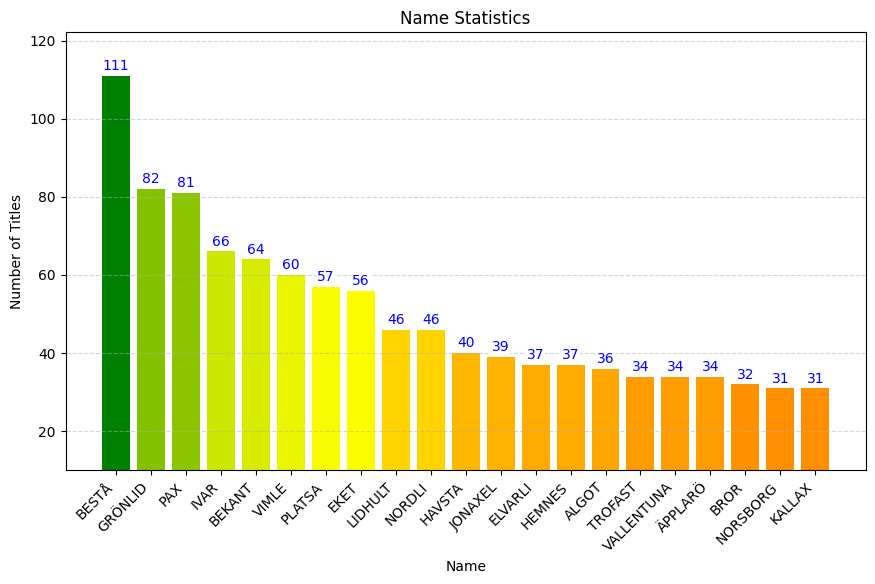

In [18]:
# 1. Price and manufacturer
# Information about products (name of the manufacturer and number of names)

# Group by 'name' and calculate the count of each name
value_counts_by_name = analysis_data.groupby("name")["price"].agg(["count"]).reset_index()

# Filter out names with a count less than 30 and sort by count in descending order
value_counts_by_name = value_counts_by_name[value_counts_by_name['count'] >= 30]\
    .sort_values('count', ascending=False).reset_index(drop=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.bar(value_counts_by_name['name'], value_counts_by_name['count'],
        color=gradient_colors(value_counts_by_name['count'] / value_counts_by_name['count'].max()))

# Adding grid lines and text labels on top of the bars
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(value_counts_by_name['count']):
    plt.text(i, v + 2.5, str(v), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.01'))

# Formatting the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Name Statistics")
plt.xlabel("Name")
plt.ylabel("Number of Titles")
plt.grid(axis='y', linestyle='--')
plt.ylim(10, value_counts_by_name['count'].max() * 1.1)
plt.subplots_adjust(bottom=0.15, left=0.1)

# Display the plot
plt.show()


In [19]:
# Descriptive statistics on the price depending on the name of the manufacturer
# Calculate descriptive statistics on the price depending on the product names
descriptive_stats_by_name = analysis_data.groupby("name")['price'].describe()

# Print the descriptive statistics
print(descriptive_stats_by_name)


                   count         mean         std     min      25%     50%  \
name                                                                         
ADDE                 1.0    40.000000         NaN    40.0    40.00    40.0   
ADILS                1.0    15.000000         NaN    15.0    15.00    15.0   
AGAM                 2.0   195.000000    0.000000   195.0   195.00   195.0   
AGEN                 1.0   245.000000         NaN   245.0   245.00   245.0   
ALEFJÄLL             1.0  1295.000000         NaN  1295.0  1295.00  1295.0   
...                  ...          ...         ...     ...      ...     ...   
ÖNSKLIG              1.0    59.000000         NaN    59.0    59.00    59.0   
ÖRFJÄLL              7.0   212.142857   16.035675   195.0   195.00   225.0   
ÖSTERNÄS             2.0    59.500000   14.849242    49.0    54.25    59.5   
ÖVRARYD              2.0   537.500000  137.885822   440.0   488.75   537.5   
ÖVRARYD / JANINGE    1.0  1535.000000         NaN  1535.0  1535.

In [20]:
# Or (let's highlight the most significant values for us)
# Calculate specific statistics on the price for each product name
price_stats_name = analysis_data.groupby("name")["price"].agg(["max", "mean", "median", "min"]).reset_index()

# Sort the results based on the maximum price in descending order
price_stats_name = price_stats_name.sort_values('max', ascending=False).reset_index(drop=True)

# Print the resulting DataFrame
print(price_stats_name)


           name     max         mean  median     min
0       LIDHULT  9585.0  3528.717391  3070.0   100.0
1       GRÖNLID  8900.0  2529.939024  1605.0    60.0
2    KONGSFJORD  8551.0  8453.500000  8453.5  8356.0
3    LANDSKRONA  8495.0  3315.000000  2747.5   100.0
4         VIMLE  8395.0  2257.166667  1657.5    50.0
..          ...     ...          ...     ...     ...
601    BERGENES     9.0     9.000000     9.0     9.0
602       HEDRA     9.0     9.000000     9.0     9.0
603        BENÖ     9.0     9.000000     9.0     9.0
604        FIXA     5.6     5.600000     5.6     5.6
605     GUBBARP     3.0     3.000000     3.0     3.0

[606 rows x 5 columns]


                           name        price
0                    KONGSFJORD  8453.500000
1         MÖRBYLÅNGA / BERNHARD  5951.000000
2                 VEDBO / VEDBO  5865.000000
3         MÖRBYLÅNGA / TOSSBERG  5465.000000
4          MÖRBYLÅNGA / BALTSAR  5370.000000
5                PAX / TYSSEDAL  5353.333333
6           EKEDALEN / BERNHARD  4620.000000
7               PAX / VINTERBRO  4390.000000
8   VÄSTANBY/VÄSTANÅ / BERNHARD  4295.000000
9         MÖRBYLÅNGA / VOLFGANG  4270.000000
10             MÖCKELBY / ODGER  4265.000000
11        MÖCKELBY / HENRIKSDAL  4265.000000
12            MÖCKELBY / FANBYN  4145.000000
13          PAX / GRIMO/VIKEDAL  4082.500000
14          MÖCKELBY / NORRARYD  4055.000000
15          INGATORP / SAKARIAS  4025.000000
16               PAX / HOKKSUND  3985.000000
17            TORSBY / BERNHARD  3875.000000
18           MÖRBYLÅNGA / ODGER  3870.000000
19           SKOGSTA / NORRARYD  3555.000000
20                      LIDHULT  3528.717391


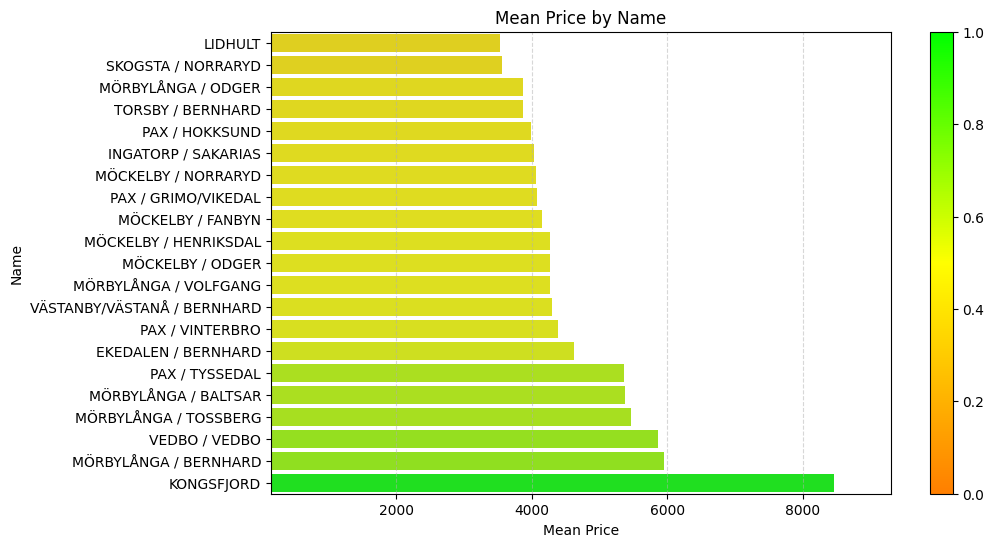

In [21]:
# Average price depending on the name of the manufacturer

# Calculate the mean price for each product name
mean_price_name = analysis_data.groupby("name")["price"].mean().reset_index()

# Sort the results based on mean price in descending order
mean_price_name = mean_price_name.sort_values('price', ascending=False).reset_index(drop=True)

# Select the top 21 results
mean_price_name = mean_price_name.iloc[:21]

# Print the resulting DataFrame
print(mean_price_name)

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])
sns.barplot(x="price", y="name", data=mean_price_name,
            palette=cmap(mean_price_name['price']/mean_price_name['price'].max()),
            orient='horizontal')

# Create a colorbar for the colormap
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax)

# Formatting the plot
ax.set_xlim(150, mean_price_name['price'].max() * 1.1)
plt.yticks(rotation=0, ha='right', fontsize=10)
plt.title("Mean Price by Name")
plt.ylabel("Name")
plt.xlabel("Mean Price")
plt.gca().invert_yaxis()  # Invert y-axis to have higher prices on top
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Display the plot
plt.show()


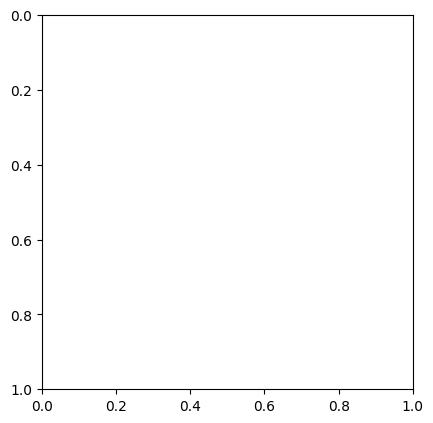

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     4.023
Date:                Sat, 12 Aug 2023   Prob (F-statistic):          1.31e-127
Time:                        17:27:57   Log-Likelihood:                -24029.
No. Observations:                2900   AIC:                         4.927e+04
Df Residuals:                    2294   BIC:                         5.289e+04
Df Model:                         605                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [22]:
# Gradient in the background
# Create a gradient colormap for the background
gradient_cmap = mcolors.LinearSegmentedColormap.from_list("", ["#002FFF", "#FF0000"])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
im = ax.imshow(gradient, cmap=gradient_cmap, aspect='auto',
               extent=[150, mean_price_name['price'].max() * 1.1, -0.5, len(mean_price_name)-0.5])

# Adding text labels for prices on the bars
for i, v in enumerate(mean_price_name['price']):
    ax.text(v + 400, i, str(round(v)), ha='center', va='center', color="black", fontsize=11,
            bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.05'))

# Adjusting subplot layout and inverting y-axis
plt.subplots_adjust(left=0.32, bottom=0.1)
plt.gca().invert_yaxis()

# Display the gradient background and the plot
plt.show()

# Fit an OLS regression model
formula = "price ~ name"
model = smf.ols(formula=formula, data=analysis_data).fit()

# Print the summary of the model
print(model.summary())


R-squared and Adjusted R-squared: The R-squared value of 0.515 indicates that the model explains 51.5% of the variance in the dependent variable (price). The adjusted R-squared value of 0.387 is slightly lower, suggesting that some independent variables might not contribute significantly to the model's explanatory power.

F-statistic and p-value: The F-statistic of 4.023 with a p-value of 1.31e-127 suggests that the overall model is statistically significant, indicating that at least one independent variable is related to the dependent variable.

Sample Size and Log-Likelihood: The model is based on 2900 observations, and the log-likelihood value is -24029.

AIC and BIC: These are measures of model fit that consider the number of parameters in the model. Lower values of AIC and BIC indicate a better fit. The AIC value is 4.927e+04, and the BIC value is 5.289e+04.

Covariance Type: The "nonrobust" covariance type assumes that standard errors of coefficients are homoskedastic (constant across all levels of independent variables) and normally distributed.

Omni Test: The omnibus test tests for normality of residuals. The test statistic is 1095.226, and the p-value is less than 0.05, suggesting that residuals are not normally distributed, which could impact the model's validity.

Durbin-Watson Test: The Durbin-Watson test tests for autocorrelation of residuals. The value of 1.810 suggests some positive autocorrelation, but it's not severe enough to invalidate the model.

Jarque-Bera Test: The Jarque-Bera test also tests for normality of residuals. The test statistic value is 9370.045, and the p-value is 0.00, indicating that residuals are not normally distributed.

Skewness and Kurtosis: The skewness value of 1.552 indicates positive skewness, and the kurtosis value of 11.241 indicates heavy-tailed distribution of residuals.

Condition Number: The condition number measures multicollinearity. A high value indicates potential problems with multicollinearity. The value of 1.33e+03 is relatively low, suggesting that multicollinearity is not a significant issue in this model.

In [23]:
# 2. Price and designers. Let's prepare a dataset for descriptive price statistics depending on the designer's name.
# Weed out unrecognizable names of designers
# Filter out rows with designer names containing digits
digit_mask = analysis_data['designer'].str.contains('\d')
digit_designer_data = analysis_data[~digit_mask].reset_index(drop=True)

# Print the resulting dataset
print(digit_designer_data)


      index   item_id                   name       category   price  \
0         0  90420332               FREKVENS  Bar furniture   265.0   
1         1    368814              NORDVIKEN  Bar furniture   995.0   
2         2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3         3  80155205                   STIG  Bar furniture    69.0   
4         4  30180504                NORBERG  Bar furniture   225.0   
...     ...       ...                    ...            ...     ...   
2793   3688  89330653      PAX / MEHAMN/AULI      Wardrobes  2045.0   
2794   3689  99157902                ELVARLI      Wardrobes   750.0   
2795   3690   9158152                ELVARLI      Wardrobes  1572.0   
2796   3691  59157541                ELVARLI      Wardrobes   924.0   
2797   3692  89157573                ELVARLI      Wardrobes  2745.0   

         old_price  sellable_online  \
0     No old price             True   
1     No old price            False   
2     No old price            

['Nicholai Wiig Hansen' 'Francis Cayouette' 'Henrik Preutz'
 'Marcus Arvonen' 'Carina Bengs' 'K Hagberg/M Hagberg' 'Sarah Fager'
 'Ehlén Johansson' 'Nike Karlsson' 'Maja Ganszyniec' 'Karl Malmvall'
 'Caroline/John/Jonas/Paul/Petrus' 'Maja Ganszyniec/Nike Karlsson'
 'J Karlsson/N Karlsson' 'IKEA of Sweden/Karl Malmvall' 'IKEA of Sweden'
 'J Karlsson/N Karlsson/Nike Karlsson' 'Ola Wihlborg'
 'IKEA of Sweden/Tina Christensen' 'IKEA of Sweden/K Hagberg/M Hagberg'
 'IKEA of Sweden/Ola Wihlborg' 'Ebba Strandmark/IKEA of Sweden'
 'Jon Karlsson' 'Carina Bengs/IKEA of Sweden' 'David Wahl'
 'IKEA of Sweden/Jon Karlsson' 'IKEA of Sweden/Paulin Machado'
 'Eva Lilja Löwenhielm/IKEA of Sweden'
 'IKEA of Sweden/Ola Wihlborg/Synnöve Mork' 'David Wahl/IKEA of Sweden'
 'Eva Lilja Löwenhielm' 'Anna Efverlund/IKEA of Sweden' 'Paulin Machado'
 'Jonas Hultqvist' 'Gustav Carlberg' 'Carl Öjerstam' 'Virgil Abloh'
 'IKEA of Sweden/Monika Mulder' 'K Legaard/T Christensen' 'Tord Björklund'
 'IKEA of Sweden/Tom Di

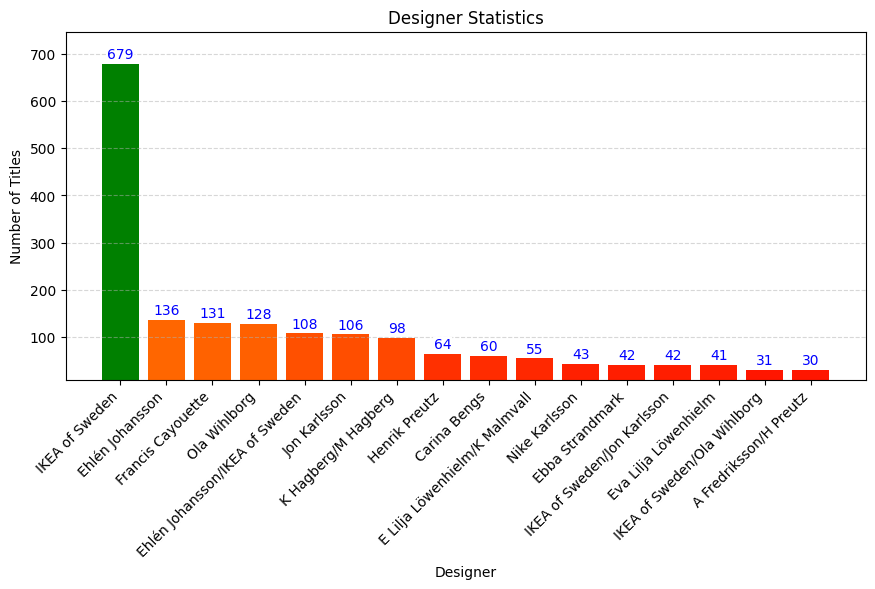

In [24]:
# Product information: names of designers and number of names by names of designers
# Get unique designer names
print(digit_designer_data["designer"].unique())

# Group by designer and calculate the count of each designer's products
value_counts_by_designer = digit_designer_data.groupby("designer")["price"].agg(["count"]).reset_index()

# Filter out designers with a count less than 30 and sort by count in descending order
value_counts_by_designer = value_counts_by_designer[value_counts_by_designer['count'] >= 30]\
    .sort_values('count', ascending=False).reset_index(drop=True)

# Create a bar plot for designer statistics
plt.figure(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.bar(value_counts_by_designer['designer'], value_counts_by_designer['count'],
        color=gradient_colors(value_counts_by_designer['count'] / value_counts_by_designer['count'].max()))

# Adding grid lines and text labels on top of the bars
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(value_counts_by_designer['count']):
    plt.text(i, v + 20, str(v), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.01'))

# Formatting the plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Designer Statistics")
plt.xlabel("Designer")
plt.ylabel("Number of Titles")
plt.grid(axis='y', linestyle='--')
plt.ylim(10, value_counts_by_designer['count'].max() * 1.1)
plt.subplots_adjust(bottom=0.3, left=0.1)

# Display the plot
plt.show()


In [25]:
# Descriptive statistics on the price depending on the name of the designer
# Calculate descriptive statistics on the price depending on the designer's name
designer_price_stats = digit_designer_data.groupby("designer")['price'].describe()

# Print the descriptive statistics
print(designer_price_stats)


                                                    count         mean  \
designer                                                                 
A Fredriksson/H Preutz                               30.0    35.600000   
A Fredriksson/HAY/J Hultqvist/W Chong                 1.0  2575.000000   
A Fredriksson/IKEA of Sweden/J Hultqvist/W Chong      1.0   675.000000   
A Fredriksson/J Hultqvist/Lisa Norinder/W Chong       1.0   889.000000   
A Fredriksson/J Hultqvist/Mikael Warnhammar/W C...    1.0  2575.000000   
...                                                   ...          ...   
Tina Christensen                                     17.0  1048.529412   
Tom Dixon                                            21.0  1334.047619   
Tord Björklund                                       26.0   528.076923   
Virgil Abloh                                          5.0   501.600000   
Wiebke Braasch                                        2.0   410.000000   

                                     

In [26]:
#Or (let's highlight the most significant values for us)
# Calculate specific statistics on the price for each designer
price_stats_designer = digit_designer_data.groupby("designer")["price"].agg(["max", "mean", "median", "min"]).reset_index()

# Sort the results based on the maximum price in descending order
price_stats_designer = price_stats_designer.sort_values('max', ascending=False).reset_index(drop=True)

# Print the resulting DataFrame
print(price_stats_designer)


                                     designer     max         mean  median  \
0                Henrik Preutz/IKEA of Sweden  9585.0  5642.363636  5553.0   
1                           Francis Cayouette  8900.0  1068.170992   477.0   
2    IKEA of Sweden/Ola Wihlborg/Synnöve Mork  8551.0  4351.500000  2663.5   
3               IKEA of Sweden/Tord Björklund  8495.0  2907.750000  2245.0   
4                             Ehlén Johansson  8395.0  1658.448529  1245.0   
..                                        ...     ...          ...     ...   
192                        A Huldén/S Dahlman    55.0    55.000000    55.0   
193                        J Karlsson/W Chong    49.0    49.000000    49.0   
194                         Charlie Styrbjörn    35.0    35.000000    35.0   
195                              Annie Huldén    30.0    27.500000    27.5   
196                           Lisel Garsveden    16.2    16.200000    16.2   

        min  
0    1285.0  
1       6.0  
2    1729.0  
3     4

                                             designer        price
0    Ehlén Johansson/Fredriksson/Hilland/L Löwenhielm  7988.000000
1                  J Marnell/Ola Wihlborg/S Lanneskog  5951.000000
2                        Henrik Preutz/IKEA of Sweden  5642.363636
3                 Carl Öjerstam/J Marnell/S Lanneskog  5370.000000
4   Ebba Strandmark/Ehlén Johansson/IKEA of Sweden...  5353.333333
5    Ehlén Johansson/Francis Cayouette/IKEA of Sweden  5044.583333
6                  Andreas Fredriksson/Marcus Arvonen  4785.000000
7                IKEA of Sweden/J Marnell/S Lanneskog  4668.333333
8                        Ehlén Johansson/Ola Wihlborg  4620.000000
9                       Ehlén Johansson/Karl Malmvall  4565.000000
10  Ehlén Johansson/Fredriksson/Hilland/IKEA of Sw...  4448.000000
11           IKEA of Sweden/Ola Wihlborg/Synnöve Mork  4351.500000
12           Chris Martin/IKEA of Sweden/Ola Wihlborg  4295.000000
13              J Löfgren/J Pettersson/Marcus Arvonen  4265.00

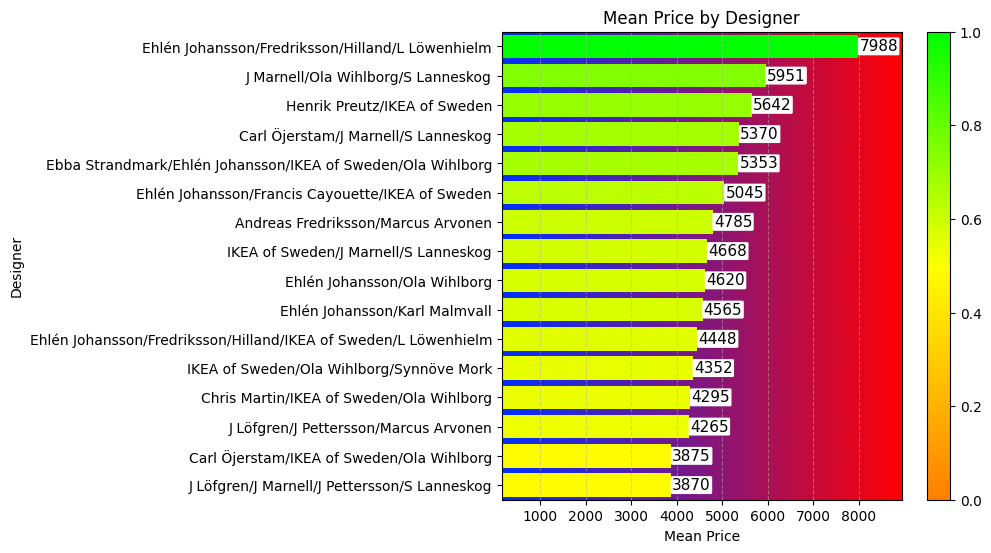

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     10.79
Date:                Sat, 12 Aug 2023   Prob (F-statistic):          7.46e-219
Time:                        17:28:48   Log-Likelihood:                -23395.
No. Observations:                2798   AIC:                         4.718e+04
Df Residuals:                    2601   BIC:                         4.835e+04
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [27]:
# Average price depending on the name of the designer
# Calculate the mean price for each designer
mean_price_designer = digit_designer_data.groupby("designer")["price"].mean().reset_index()
mean_price_designer = mean_price_designer.sort_values('price', ascending=False).reset_index(drop=True)
mean_price_designer = mean_price_designer.iloc[:16]
print(mean_price_designer)

# Create a horizontal bar plot to visualize mean prices by designer
fig, ax = plt.subplots(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])
bar_heights = np.arange(len(mean_price_designer))
bar_widths = mean_price_designer['price']
colors = cmap(mean_price_designer['price']/mean_price_designer['price'].max())
ax.barh(bar_heights, bar_widths, color=colors)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_xlim(150, mean_price_designer['price'].max() * 1.12)
ax.set_yticks(bar_heights)
ax.set_yticklabels(mean_price_designer['designer'])
plt.title("Mean Price by Designer")
plt.ylabel("Designer")
plt.xlabel("Mean Price")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add a gradient background
gradient_cmap = mcolors.LinearSegmentedColormap.from_list("", ["#002FFF", "#FF0000"])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
im = ax.imshow(gradient, cmap=gradient_cmap, aspect='auto',
               extent=[150, mean_price_designer['price'].max() * 1.12, -0.5, len(mean_price_designer)-0.5])

# Adding text labels for prices on the bars
for i, v in enumerate(mean_price_designer['price']):
    ax.text(v + 450, i, str(round(v)), ha='center', va='center', color="black", fontsize=11,
            bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.05'))

# Adjusting subplot layout and inverting y-axis
plt.subplots_adjust(left=0.4, bottom=0.1)
plt.gca().invert_yaxis()

# Display the plot
plt.show()

# Fit an OLS regression model
formula = "price ~ designer"
model = smf.ols(formula=formula, data=digit_designer_data).fit()

# Print the summary of the model
print(model.summary())


R-squared and Adjusted R-squared: The R-squared value of 0.448 indicates that approximately 44.8% of the variability in the dependent variable (price) can be explained by the predictor variables in the model. The adjusted R-squared value of 0.407 takes into account the number of predictor variables in the model and adjusts the R-squared value accordingly.

F-Statistic: The F-statistic of 10.79 with a corresponding p-value of 7.46e-219 suggests that at least one of the predictor variables is significantly related to the dependent variable. This implies that the overall model is statistically significant.

Log-Likelihood and AIC/BIC: The logarithmic value of the model's likelihood is -23395, which is used for model comparison and assessing fit. Lower values of AIC and BIC indicate better model fit. These criteria help in comparing the current model with other models.

Covariance Type: The instability of the covariance type implies that the model is sensitive to outliers. This could affect the model's performance and interpretation.

Omnibus Test: The Omnibus test statistic of 1331.561 with a p-value of 0.000 indicates that the residuals are not normally distributed. This violates one of the assumptions of linear regression and may impact the reliability of the results.

Durbin-Watson Test: The Durbin-Watson test statistic of 1.817 suggests that there might be some positive autocorrelation in the residuals, although it is not severe enough to invalidate the results.

Jarque-Bera Test: The Jarque-Bera statistic of 10710.006 and a p-value of 0.00 indicate that the residuals do not follow a normal distribution. This supports the findings of the Omnibus test.

Skewness and Kurtosis: The skewness value of 2.092 indicates positive skewness in the distribution of residuals, and the kurtosis value of 11.623 suggests heavy tails and sharper peaks compared to a normal distribution.

Condition Number: The condition number of 146 is a measure of multicollinearity in the model. A higher value indicates a higher degree of multicollinearity, which can complicate the interpretation of individual coefficients. However, the value of 146 suggests that multicollinearity is not a significant problem in this model.

In [28]:
# 3. Prices and product categories
# Product Information: Product Categories and Number of Items by Category
# Print the unique product categories
print(analysis_data["category"].unique())

# Print the number of items in each product category
print(analysis_data["category"].value_counts())


['Bar furniture' 'Beds' 'Bookcases & shelving units'
 'Cabinets & cupboards' 'Café furniture' 'Chairs'
 'Chests of drawers & drawer units' "Children's furniture"
 'Nursery furniture' 'Outdoor furniture' 'Room dividers'
 'Sideboards, buffets & console tables' 'Sofas & armchairs'
 'Tables & desks' 'Trolleys' 'TV & media furniture' 'Wardrobes']
Bookcases & shelving units              539
Chairs                                  426
Sofas & armchairs                       379
Tables & desks                          370
Beds                                    207
Outdoor furniture                       197
Wardrobes                               190
Cabinets & cupboards                    186
Chests of drawers & drawer units        111
TV & media furniture                     87
Children's furniture                     80
Bar furniture                            47
Trolleys                                 23
Nursery furniture                        20
Café furniture                          

In [29]:
#or
# Group data by product category and calculate the count of items in each category
value_counts_by_category = analysis_data.groupby("category")['price'].agg(["count"]).reset_index()

# Sort the results in descending order based on the count of items
value_counts_by_category = value_counts_by_category.sort_values('count', ascending=False).reset_index(drop=True)

# Print the product categories and their corresponding item counts
print(value_counts_by_category)


                                category  count
0             Bookcases & shelving units    539
1                                 Chairs    426
2                      Sofas & armchairs    379
3                         Tables & desks    370
4                                   Beds    207
5                      Outdoor furniture    197
6                              Wardrobes    190
7                   Cabinets & cupboards    186
8       Chests of drawers & drawer units    111
9                   TV & media furniture     87
10                  Children's furniture     80
11                         Bar furniture     47
12                              Trolleys     23
13                     Nursery furniture     20
14                        Café furniture     18
15  Sideboards, buffets & console tables     10
16                         Room dividers     10


In [30]:
#or
# Calculate and print the count of items in each product category
print(analysis_data.groupby("category")['price'].count())


category
Bar furniture                            47
Beds                                    207
Bookcases & shelving units              539
Cabinets & cupboards                    186
Café furniture                           18
Chairs                                  426
Chests of drawers & drawer units        111
Children's furniture                     80
Nursery furniture                        20
Outdoor furniture                       197
Room dividers                            10
Sideboards, buffets & console tables     10
Sofas & armchairs                       379
TV & media furniture                     87
Tables & desks                          370
Trolleys                                 23
Wardrobes                               190
Name: price, dtype: int64


category
Bar furniture                            47
Beds                                    207
Bookcases & shelving units              539
Cabinets & cupboards                    186
Café furniture                           18
Chairs                                  426
Chests of drawers & drawer units        111
Children's furniture                     80
Nursery furniture                        20
Outdoor furniture                       197
Room dividers                            10
Sideboards, buffets & console tables     10
Sofas & armchairs                       379
TV & media furniture                     87
Tables & desks                          370
Trolleys                                 23
Wardrobes                               190
Name: price, dtype: int64


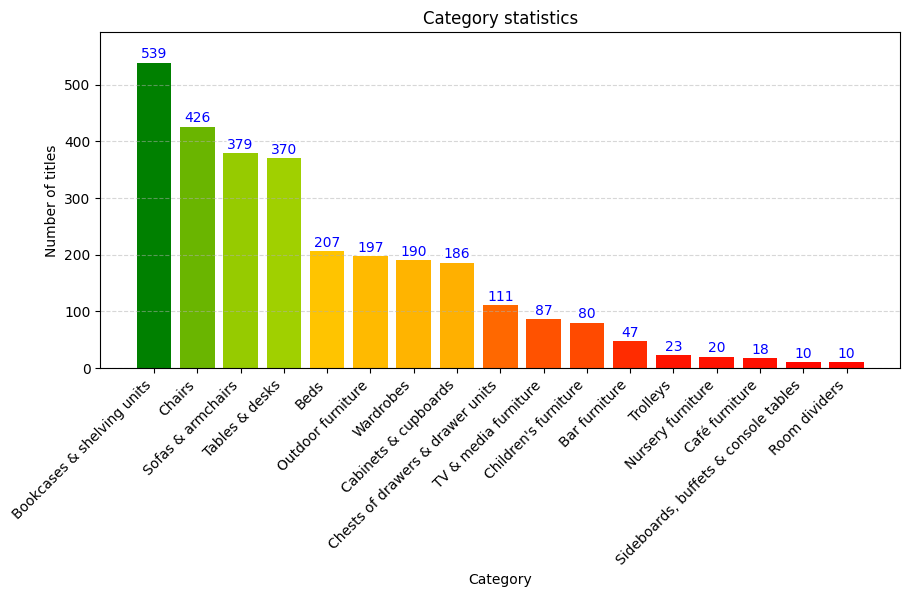

In [31]:
#or
# Print the size (count) of items in each product category
print(analysis_data.groupby("category")['price'].size())

# Create a bar chart to visualize the number of items in each category
plt.figure(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.bar(value_counts_by_category['category'], value_counts_by_category['count'],
        color=gradient_colors(value_counts_by_category['count'] / value_counts_by_category['count'].max()))
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate(value_counts_by_category['count']):
    plt.text(i, v + 15, str(v), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.01'))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Category statistics")
plt.xlabel("Category")
plt.ylabel("Number of titles")
plt.grid(axis='y', linestyle='--')
plt.ylim(0, value_counts_by_category['count'].max() * 1.1)
plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


In [32]:
#Descriptive statistics on the price depending on the category
# Calculate and print the descriptive statistics of prices for each product category
print(analysis_data.groupby("category")['price'].describe())


                                      count         mean          std    min  \
category                                                                       
Bar furniture                          47.0   679.553191   604.600148   40.0   
Beds                                  207.0  1632.004831  1798.566923   30.0   
Bookcases & shelving units            539.0   507.282004   625.426219    3.0   
Cabinets & cupboards                  186.0  1041.198925  1043.824015   22.0   
Café furniture                         18.0   426.722222   283.589348  145.0   
Chairs                                426.0  1050.494366  1310.778506   11.4   
Chests of drawers & drawer units      111.0   657.490991   450.825440   49.0   
Children's furniture                   80.0   285.112500   289.662702    5.0   
Nursery furniture                      20.0   452.950000   367.077286   25.0   
Outdoor furniture                     197.0   919.759391  1201.705664    9.0   
Room dividers                          1

                                category     max         mean   median    min
0                      Sofas & armchairs  9585.0  1960.580475  1140.00   27.0
1                                   Beds  9585.0  1632.004831  1092.00   30.0
2                              Wardrobes  8380.0  2109.871053  1768.75   45.0
3                                 Chairs  6965.0  1050.494366   470.00   11.4
4                         Tables & desks  6614.0   760.129730   475.00    9.0
5                   Cabinets & cupboards  6480.0  1041.198925   843.00   22.0
6                      Outdoor furniture  5144.0   919.759391   345.00    9.0
7             Bookcases & shelving units  4335.0   507.282004   295.00    3.0
8                   TV & media furniture  4175.0  1022.793103   820.00   17.0
9                          Room dividers  2397.0   912.600000   595.00  189.0
10                         Bar furniture  2375.0   679.553191   445.00   40.0
11                              Trolleys  2295.0   748.869565   

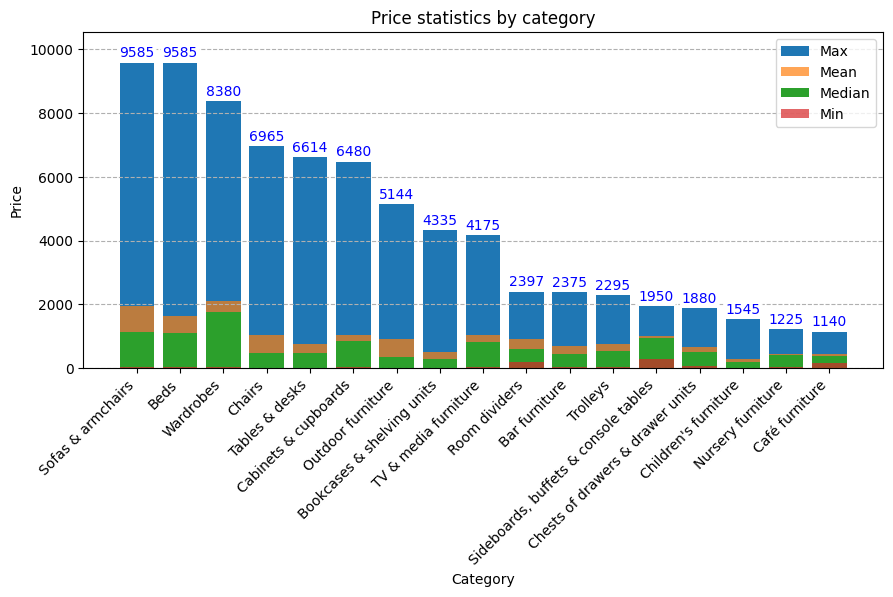

In [33]:
#Or (let's highlight the most significant values for us)
# Calculate maximum, mean, median, and minimum prices for each product category
price_stats = analysis_data.groupby("category")["price"].agg(["max", "mean", "median", "min"]).reset_index()
price_stats = price_stats.sort_values('max', ascending=False).reset_index(drop=True)
print(price_stats)

# Create a bar chart to visualize price statistics by category
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(price_stats['category'], price_stats["max"], label="Max")
ax.bar(price_stats['category'], price_stats["mean"], label="Mean", alpha=0.7)
ax.bar(price_stats['category'], price_stats["median"], label="Median")
ax.bar(price_stats['category'], price_stats["min"], label="Min", alpha=0.7)
plt.ylim(0, price_stats["max"].max() * 1.1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Price statistics by category")
plt.xlabel("Category")
plt.ylabel("Price")
plt.legend()
plt.grid(axis='y', linestyle='--')
for i, v in enumerate(price_stats["max"]):
    plt.text(i, v+300, str(round(v)), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.1'))
plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


                                category        price
0                              Wardrobes  2109.871053
1                      Sofas & armchairs  1960.580475
2                                   Beds  1632.004831
3                                 Chairs  1050.494366
4                   Cabinets & cupboards  1041.198925
5                   TV & media furniture  1022.793103
6   Sideboards, buffets & console tables  1013.000000
7                      Outdoor furniture   919.759391
8                          Room dividers   912.600000
9                         Tables & desks   760.129730
10                              Trolleys   748.869565
11                         Bar furniture   679.553191
12      Chests of drawers & drawer units   657.490991
13            Bookcases & shelving units   507.282004
14                     Nursery furniture   452.950000
15                        Café furniture   426.722222
16                  Children's furniture   285.112500


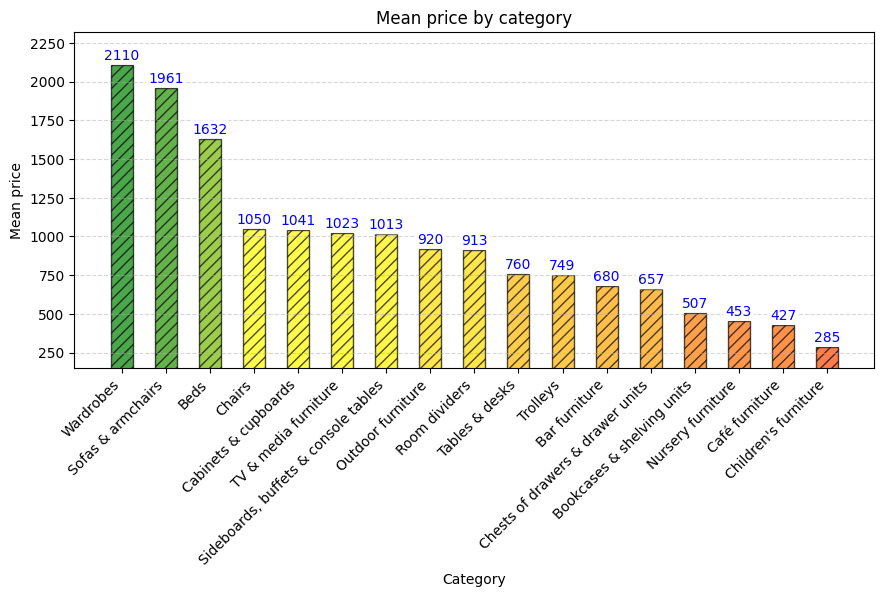

In [34]:
# Average price depending on the category
# Calculate the mean price for each product category
mean_price = analysis_data.groupby("category")["price"].mean().reset_index()
mean_sort_price = mean_price.sort_values('price', ascending=False).reset_index(drop=True)
print(mean_sort_price)

# Create a bar chart to visualize the mean price by category
fig, ax = plt.subplots(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

ax.bar(mean_sort_price['category'], mean_sort_price['price'],
       color=gradient_colors(mean_sort_price['price']/mean_sort_price['price'].max()),
       width=0.5, edgecolor='black', linewidth=1, alpha=0.7, align='center',
       capsize=7, ecolor='gray', hatch='///',
       error_kw=dict(elinewidth=1, capsize=3, capthick=1))

ax.set_xticks(range(len(mean_sort_price['category'])))
ax.set_xticklabels(mean_sort_price['category'], rotation=45, ha='right', fontsize=10)
ax.set_title("Mean price by category")
ax.set_xlabel("Category")
ax.set_ylabel("Mean price")
ax.set_ylim(150, mean_sort_price['price'].max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)

for i, v in enumerate(mean_sort_price['price']):
    ax.text(i, v+60, str(round(v)), ha='center', va='center', color="b",
            bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.1'))

plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


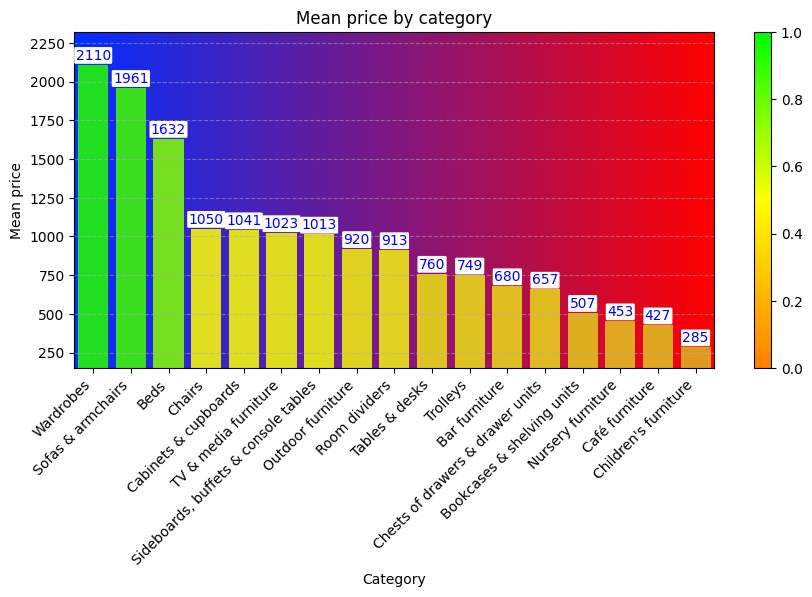

In [35]:
#or
fig, ax = plt.subplots(figsize=(10, 6))
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])

sns.barplot(x="category", y="price", data=mean_sort_price,
            palette=cmap(mean_sort_price['price']/mean_sort_price['price'].max()))

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax)

ax.set_ylim(150, mean_sort_price['price'].max() * 1.1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Mean price by category")
plt.xlabel("Category")
plt.ylabel("Mean price")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding a gradient to the background
gradient_cmap = mcolors.LinearSegmentedColormap.from_list("", ["#002FFF", "#FF0000"])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
im = ax.imshow(gradient, cmap=gradient_cmap, aspect='auto', extent=[-0.5, len(mean_sort_price)-0.5, 0,
mean_sort_price['price'].max() * 1.1])

for i, v in enumerate(mean_sort_price['price']):
    ax.text(i, v + 60, str(round(v)), ha='center', va='center', color="b",
            bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.05'))

plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


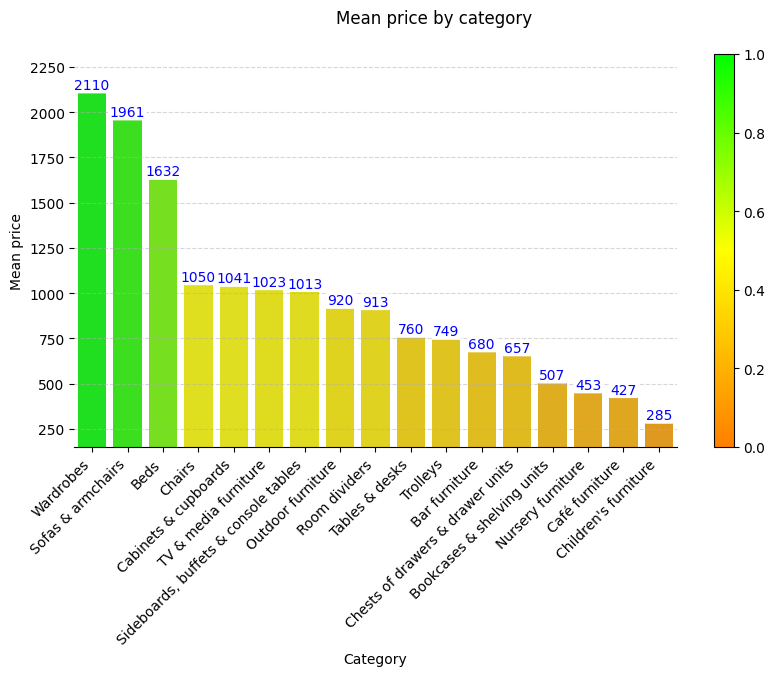

In [36]:
#or
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FF7F00", "#FFFF00", "#00FF00"])

g = sns.catplot(x="category", y="price", data=mean_sort_price, kind="bar", height=6, aspect=1.5,
                palette=cmap(mean_sort_price['price']/mean_sort_price['price'].max()))

g.fig.suptitle("Mean price by category", y=1.05)
g.set_xlabels("Category")
g.set_ylabels("Mean price")
g.set(ylim=(150, mean_sort_price['price'].max() * 1.1))
g.despine(left=True)
g.ax.grid(axis='y', linestyle='--', alpha=0.5)

for i, v in enumerate(mean_sort_price['price']):
    g.ax.text(i, v + 40, str(round(v)), ha='center', va='center', color="b",
              bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.05'))

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
g.fig.colorbar(sm, ax=g.ax)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


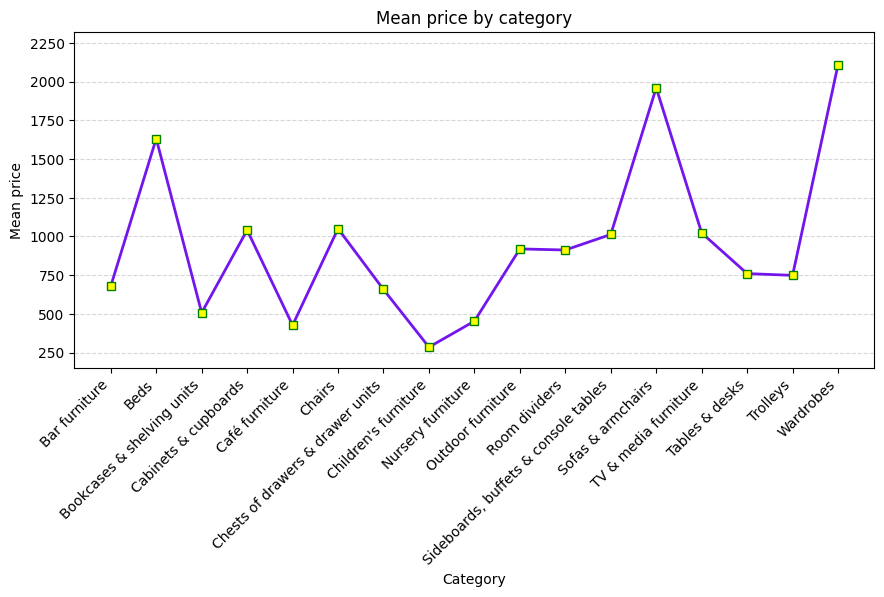

In [37]:
#or
plt.figure(figsize=(10, 6))
plt.plot(mean_price['category'], mean_price['price'], marker='s', linewidth="2",
         color="#7315ed", mec='green', mfc="yellow")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Mean price by category")
plt.xlabel("Category")
plt.ylabel("Mean price")
plt.ylim(150, mean_price['price'].max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.32, left=0.1)
plt.show()


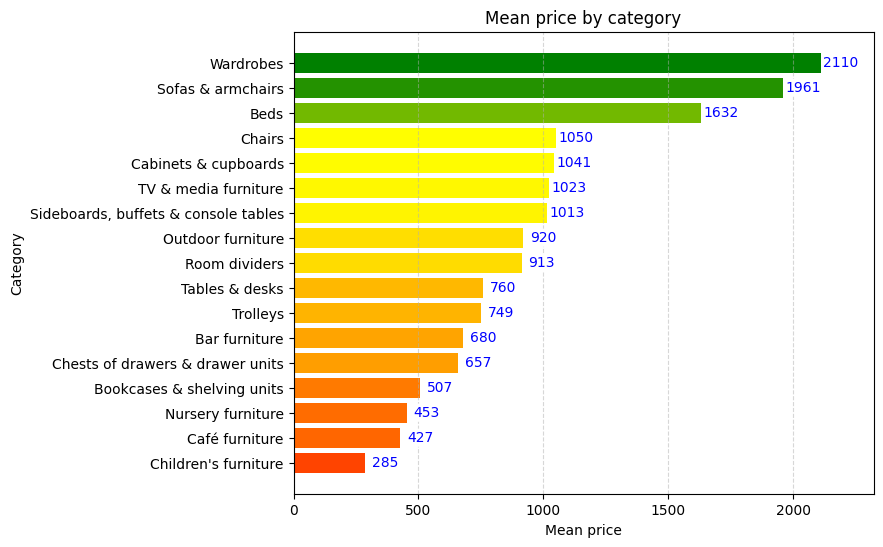

In [38]:
#or
plt.figure(figsize=(10, 6))
gradient_colors = mcolors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.barh(mean_sort_price['category'], mean_sort_price['price'],
         color=gradient_colors(mean_sort_price['price']/mean_sort_price['price'].max()))
plt.title("Mean price by category")
plt.xlabel("Mean price")
plt.ylabel("Category")
plt.xlim(0, mean_sort_price['price'].max() * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
for i, v in enumerate(mean_sort_price['price']):
    plt.text(v+80, i, str(round(v)), ha='center', va='center', color="b",
             bbox=dict(facecolor='white', edgecolor='w', boxstyle='round,pad=0.1'))
plt.subplots_adjust(left=0.32)
plt.gca().invert_yaxis()
plt.show()


OLS methods
R-squared and Adjusted R-squared: The R-squared value of 0.159 indicates that approximately 15.9% of the variance in the dependent variable can be explained by the predictor variables in the model. The adjusted R-squared (0.154) accounts for the number of predictor variables in the model and provides a slightly lower value.

F-Statistic: The F-statistic value of 34.05 with a very low p-value (3.08e-96) suggests strong evidence that at least one of the predictor variables is significantly related to the dependent variable.

Log-Likelihood and Information Criteria: The log-likelihood value of -24827 is used to compare models and assess their fit. Information criteria like AIC and BIC are useful for model comparison.

Covariance Type: The covariance type is unreliable, indicating that the model is sensitive to outliers and influential observations.

Overall Model Assessment: The model has a relatively low R-squared value, suggesting that the predictor variables are not strong predictors of the dependent variable. The F-statistic is significant, indicating a significant relationship between the predictor variables and the dependent variable, but the effect size is relatively small.

Tests for Assumptions:

Omnibus Test: The value of 1299.027 for the Omnibus test indicates that the residuals are not normally distributed, violating one of the assumptions of linear regression.
Durbin-Watson Statistic: A value of 1.708 suggests the presence of some positive autocorrelation in the residuals, but it's not severe enough to invalidate the results.
Jarque-Bera Test (JB): The JB test value of 7022.093 and a p-value of 0.00 also indicate that the residuals are not normally distributed, corroborating the result of the Omnibus test.
Skewness and Kurtosis: The skewness value of 2.101 indicates positive skewness, and the excess kurtosis value of 9.360 suggests that the distribution has more peakedness than a normal distribution.
Condition Number: The condition number of 35.5 is a measure of multicollinearity. A higher value indicates higher multicollinearity, but 35.5 suggests that multicollinearity is not a significant issue in this model

In [39]:
# 4. Prices & Sizes
# Let's prepare a dataset for estimating the correlation of prices depending on the size.
analysis_data = analysis_data[["price", "depth", "height", "width"]]
analysis_data = analysis_data.dropna(subset=["depth", "height", "width"])
print(analysis_data)

       price  depth  height  width
3       69.0   50.0   100.0   60.0
4      225.0   60.0    43.0   74.0
5      345.0   45.0    91.0   40.0
6      129.0   44.0    95.0   50.0
8      129.0   44.0    95.0   50.0
...      ...    ...     ...    ...
3683  1260.0   60.0   201.0   75.0
3684  1245.0   55.0   216.0  164.0
3685  2100.0   60.0   236.0  100.0
3686  3985.0   66.0   236.0  150.0
3688  2045.0   66.0   236.0  200.0

[1554 rows x 4 columns]


In [40]:
# Calculate the correlation between the price and volume of goods
analysis_data['size'] = analysis_data['width'] * analysis_data["depth"] * analysis_data["height"]
correlation = analysis_data["price"].corr(analysis_data['size'])
print(correlation)

0.8233616402808842


In [41]:
#or
corr = analysis_data[['size', 'price']].corr()
print(corr)

           size     price
size   1.000000  0.823362
price  0.823362  1.000000


In [42]:
#or
print(pearsonr(analysis_data["price"], analysis_data["size"]))

PearsonRResult(statistic=0.8233616402808847, pvalue=0.0)


The Pearson correlation coefficient between "price" and "size" is 0.8233616402808847, which indicates a strong positive correlation between these two variables. A positive correlation means that as the size of the object increases, the price also tends to increase, and vice versa. The p-value of 0.0 indicates that the probability of observing such a strong correlation purely by chance is effectively zero. Therefore, you can confidently conclude that there is a significant correlation between the "price" and "size" variables in the dataset.

In [43]:
# Deviation
z_scores = zscore(analysis_data['size'])
outliers = (z_scores > 3)
print(analysis_data[outliers])


       price  depth  height  width        size
190   9585.0  164.0   102.0  387.0   6473736.0
221   4790.0  164.0   104.0  277.0   4724512.0
248   5840.0  164.0   102.0  298.0   4984944.0
251   7873.0  164.0   102.0  298.0   4984944.0
2233  6545.0  163.0    83.0  387.0   5235723.0
2236  3590.0  164.0   104.0  328.0   5594368.0
2278  3190.0  164.0   104.0  258.0   4400448.0
2283  6575.0  252.0   104.0  327.0   8570016.0
2289  8295.0  257.0    83.0  368.0   7849808.0
2344  9585.0  164.0   102.0  387.0   6473736.0
2358  5945.0  163.0    83.0  347.0   4694563.0
2376  4695.0  164.0   102.0  349.0   5838072.0
2384  5040.0  164.0   104.0  277.0   4724512.0
2385  6895.0  257.0    83.0  328.0   6996568.0
2387  8395.0  249.0    83.0  327.0   6758109.0
2411  4865.0  164.0   104.0  339.0   5781984.0
2445  8240.0  164.0   102.0  367.0   6139176.0
2463  5428.0  164.0   102.0  279.0   4667112.0
2508  4495.0  164.0   102.0  279.0   4667112.0
2538  4100.0  164.0   104.0  258.0   4400448.0
2544  6295.0 

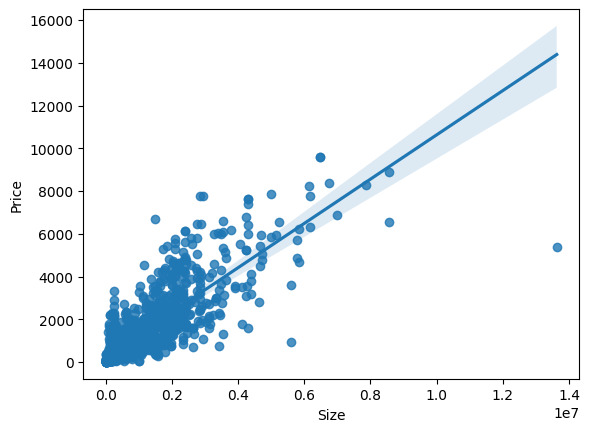

In [44]:
#or
sns.regplot(x='size', y='price', data=analysis_data)
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()


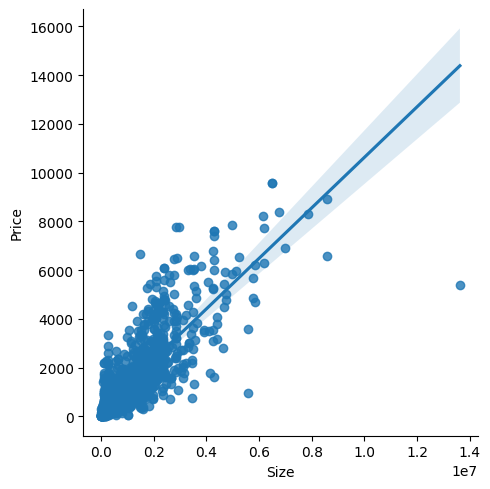

In [45]:
#or
g = sns.FacetGrid(analysis_data, height=5)
g.map(sns.regplot, 'size', 'price')
g.set_axis_labels('Size', 'Price')
plt.show()

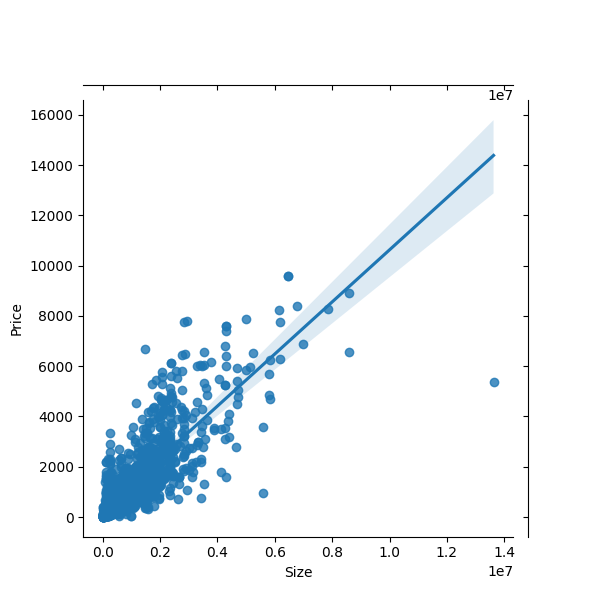

In [46]:
#or
grid = sns.JointGrid(x='size', y='price', data=analysis_data)
grid.plot_joint(sns.regplot)
grid.set_axis_labels(xlabel='Size', ylabel='Price')
plt.show()

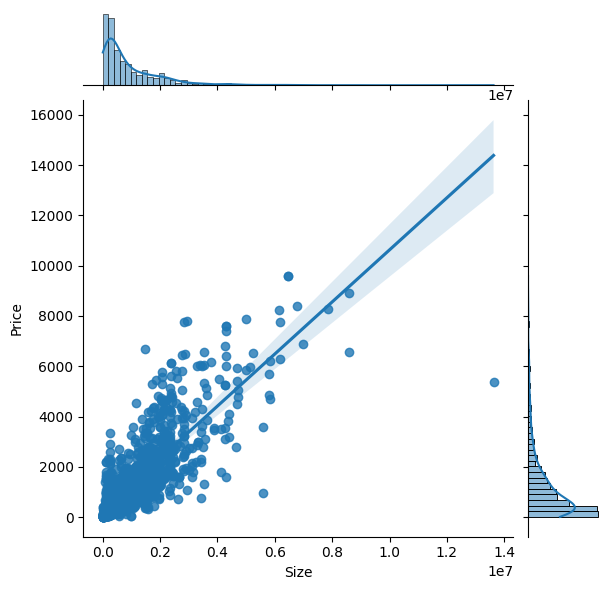

In [ ]:
#or
sns.jointplot(x='size', y='price', data=analysis_data, kind='reg')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

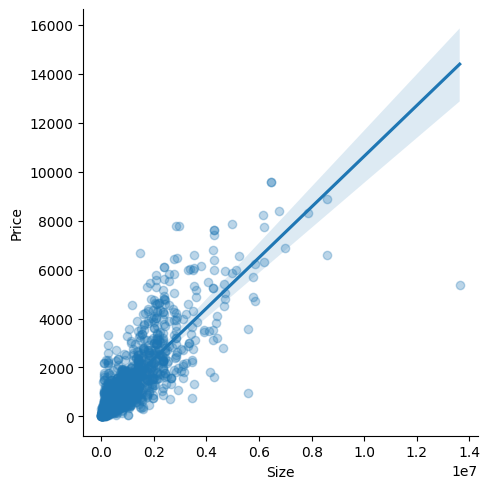

In [ ]:
# or
sns.lmplot(x='size', y='price', data=analysis_data, scatter_kws={'alpha':0.3})
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

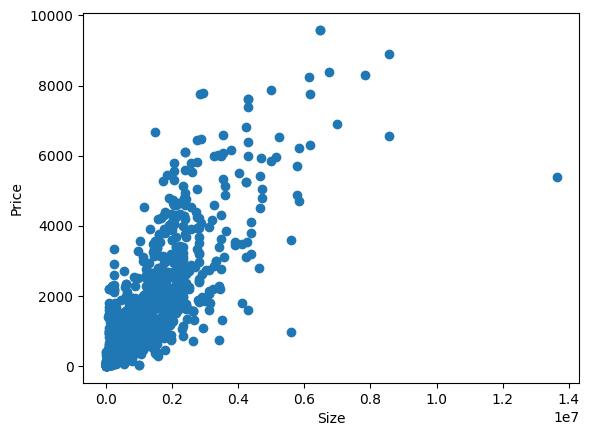

In [ ]:
# or
plt.scatter(analysis_data['size'], analysis_data['price'])
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()

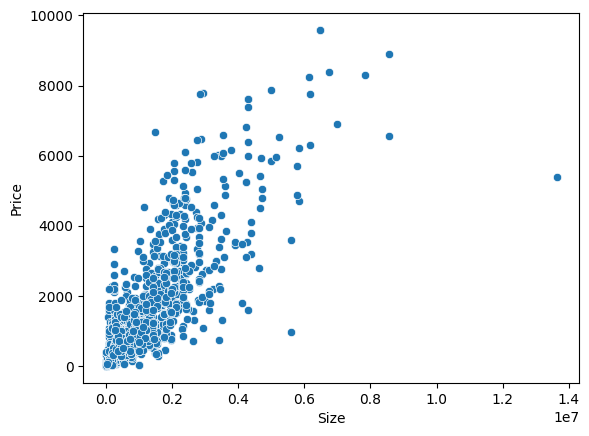

In [ ]:
# or
sns.scatterplot(x=analysis_data['size'], y=analysis_data['price'])
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()


In [ ]:
analysis_data = analysis_data[["price", "depth", "height", "width"]]
analysis_data = analysis_data.dropna(subset=["depth", "height", "width"])
print(analysis_data)

       price  depth  height  width
3       69.0   50.0   100.0   60.0
4      225.0   60.0    43.0   74.0
5      345.0   45.0    91.0   40.0
6      129.0   44.0    95.0   50.0
8      129.0   44.0    95.0   50.0
...      ...    ...     ...    ...
3683  1260.0   60.0   201.0   75.0
3684  1245.0   55.0   216.0  164.0
3685  2100.0   60.0   236.0  100.0
3686  3985.0   66.0   236.0  150.0
3688  2045.0   66.0   236.0  200.0

[1554 rows x 4 columns]


In [ ]:
# Calculate the pairwise correlation between numeric columns
correlation_matrix = analysis_data.corr()
print(correlation_matrix)

           price     depth    height     width
price   1.000000  0.635030  0.227821  0.768489
depth   0.635030  1.000000 -0.105482  0.427046
height  0.227821 -0.105482  1.000000  0.296592
width   0.768489  0.427046  0.296592  1.000000


In [ ]:
# or
print(pearsonr(analysis_data["price"], analysis_data["width"]))
print(pearsonr(analysis_data["price"], analysis_data["depth"]))
print(pearsonr(analysis_data["price"], analysis_data["height"]))


PearsonRResult(statistic=0.7684890768124379, pvalue=2.934370688566216e-303)
PearsonRResult(statistic=0.6350304682463238, pvalue=3.238965773460235e-176)
PearsonRResult(statistic=0.22782104476991735, pvalue=9.590067924168572e-20)


There is a strong positive correlation between "price" and "width" (correlation coefficient 0.768). This indicates that as the width of the object increases, the price also tends to increase. The very small p-value (2.93e-303) indicates that this correlation is statistically significant.

There is a moderate positive correlation between "price" and "depth" (correlation coefficient 0.635). This suggests that as the depth of the object increases, the price has a tendency to increase. The small p-value (3.24e-176) confirms the statistical significance of this correlation.

There is a weak positive correlation between "price" and "height" (correlation coefficient 0.228). This indicates a slight tendency for the price to increase with the height of the object. The low p-value (9.59e-20) indicates the statistical significance of this correlation.

Overall, "width" and "depth" are important factors in determining the price of an object, while "height" has a weaker relationship with price.

The results collectively demonstrate a strong positive linear relationship between price and both depth and height, as well as a weaker but statistically significant positive linear relationship between price and width

In [ ]:
# Deviation
z_scores = zscore(analysis_data)
abs_z_scores = np.abs(z_scores)
outlier_indices = np.where(abs_z_scores > 3)[0]
outliers = analysis_data.iloc[outlier_indices]
print(outliers)

       price  depth  height  width
179   7610.0  164.0   104.0  252.0
179   7610.0  164.0   104.0  252.0
190   9585.0  164.0   102.0  387.0
190   9585.0  164.0   102.0  387.0
190   9585.0  164.0   102.0  387.0
...      ...    ...     ...    ...
3580  5965.0   58.0   236.0  375.0
3580  5965.0   58.0   236.0  375.0
3586  3113.0   42.0   241.0  420.0
3599  6805.0   60.0   236.0  300.0
3623  1324.0   42.0   221.0  380.0

[109 rows x 4 columns]


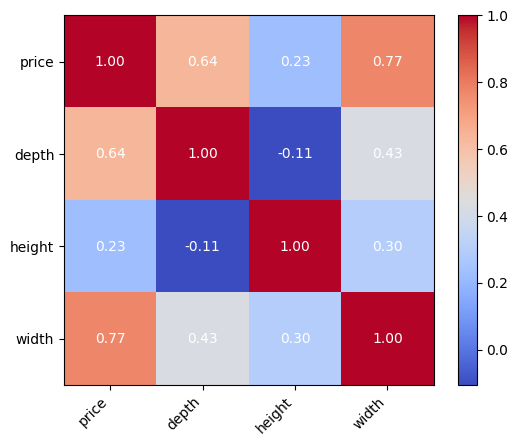

In [ ]:
#heatmaps
correlation_matrix.index = correlation_matrix.index.map(str)
correlation_matrix.columns = correlation_matrix.columns.map(str)
fig, ax = plt.subplots()
im = ax.imshow(correlation_matrix, cmap='coolwarm')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(['price', 'depth', 'height', 'width'])))
ax.set_yticks(np.arange(len(['price', 'depth', 'height', 'width'])))
ax.set_xticklabels(['price', 'depth', 'height', 'width'], rotation=45, ha="right")
ax.set_yticklabels(['price', 'depth', 'height', 'width'])
for i in range(len(['price', 'depth', 'height', 'width'])):
    for j in range(len(['price', 'depth', 'height', 'width'])):
        text = ax.text(j, i, '{:.2f}'.format(correlation_matrix.iloc[i, j]), ha="center", va="center", color="w")
plt.show()


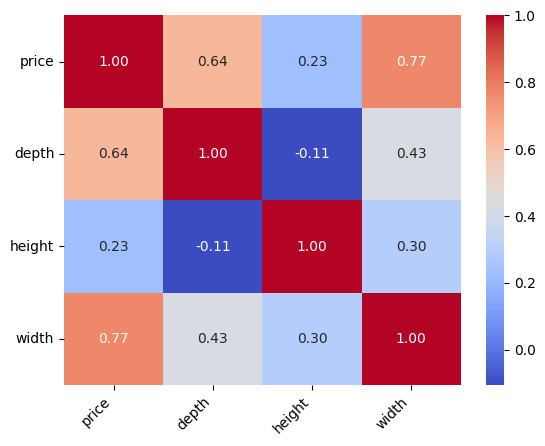

In [ ]:
# or
fig, ax = plt.subplots()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
ax.set_xticklabels(['price', 'depth', 'height', 'width'], rotation=45, ha="right")
ax.set_yticklabels(['price', 'depth', 'height', 'width'], rotation=0)
plt.show()


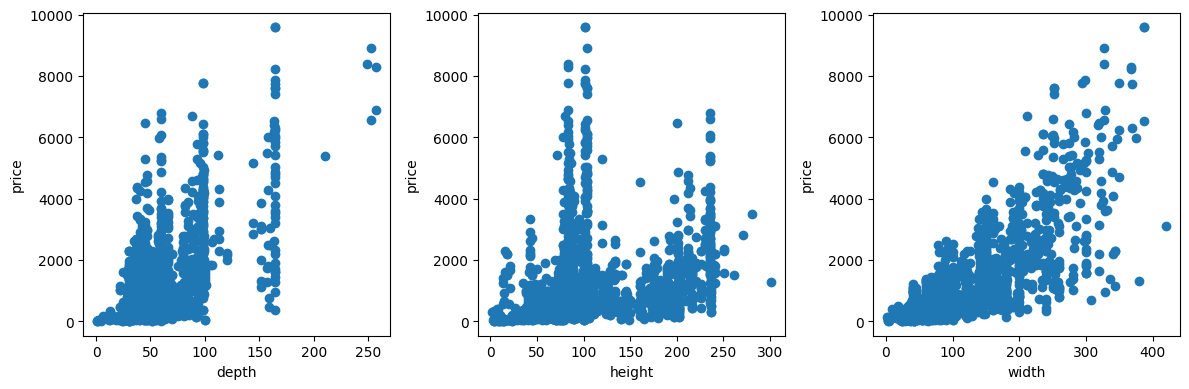

In [ ]:
# Graphics
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].scatter(analysis_data['depth'], analysis_data['price'])
axes[0].set_xlabel('depth')
axes[0].set_ylabel('price')
axes[1].scatter(analysis_data['height'], analysis_data['price'])
axes[1].set_xlabel('height')
axes[1].set_ylabel('price')
axes[2].scatter(analysis_data['width'], analysis_data['price'])
axes[2].set_xlabel('width')
axes[2].set_ylabel('price')
plt.tight_layout()
plt.show()


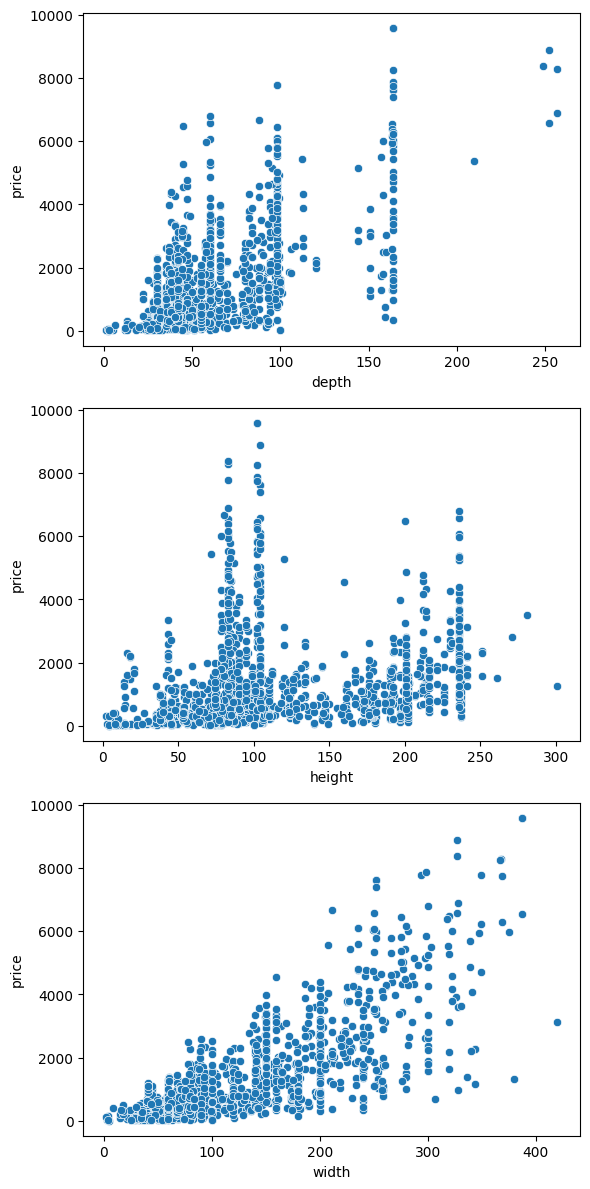

In [ ]:
# or
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,12))
sns.scatterplot(data=analysis_data, x='depth', y='price', ax=axes[0])
axes[0].set_xlabel('depth')
axes[0].set_ylabel('price')
sns.scatterplot(data=analysis_data, x='height', y='price', ax=axes[1])
axes[1].set_xlabel('height')
axes[1].set_ylabel('price')
sns.scatterplot(data=analysis_data, x='width', y='price', ax=axes[2])
axes[2].set_xlabel('width')
axes[2].set_ylabel('price')
plt.tight_layout()
plt.show()


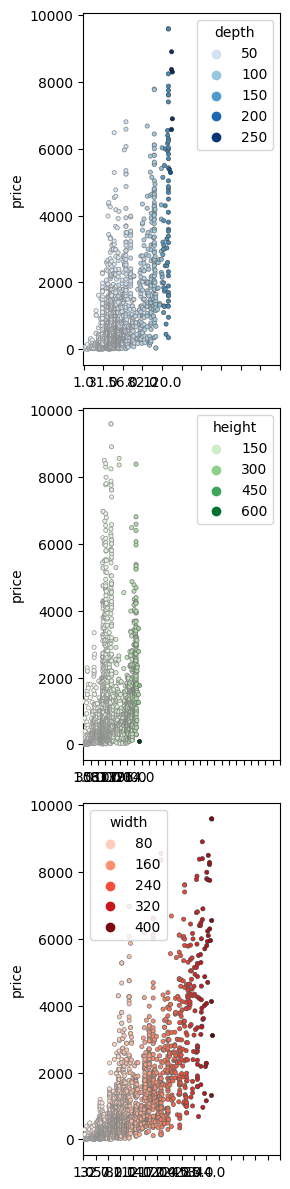

In [ ]:
# or
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(3, 12))
sns.stripplot(data=analysis_data, x='depth', y='price', ax=axes[0], size=3, linewidth=0.5,
palette='Blues', hue='depth')
axes[0].set_ylabel('price')
axes[0].set_xticks(range(0, int(analysis_data['depth'].max()), 25))
axes[0].set_xlabel('')
sns.stripplot(data=analysis_data, x='height', y='price', ax=axes[1], size=3, linewidth=0.5,
palette='Greens', hue='height')
axes[1].set_ylabel('price')
axes[1].set_xticks(range(0, int(analysis_data['height'].max()), 25))
axes[1].set_xlabel('')
sns.stripplot(data=analysis_data, x='width', y='price', ax=axes[2], size=3, linewidth=0.5,
palette='Reds', hue='width')
axes[2].set_ylabel('price')
axes[2].set_xticks(range(0, int(analysis_data['width'].max()), 25))
axes[2].set_xlabel('')
plt.tight_layout()
plt.show()


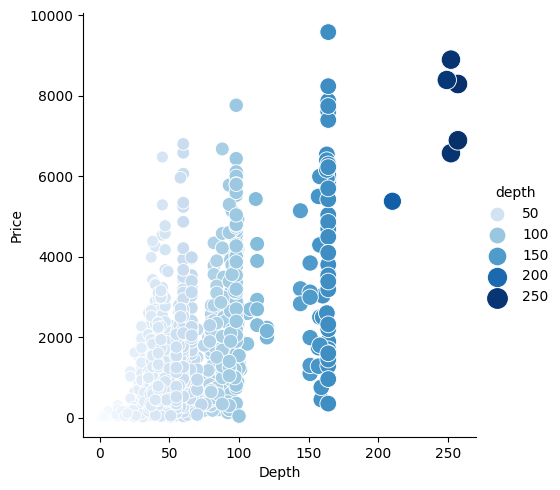

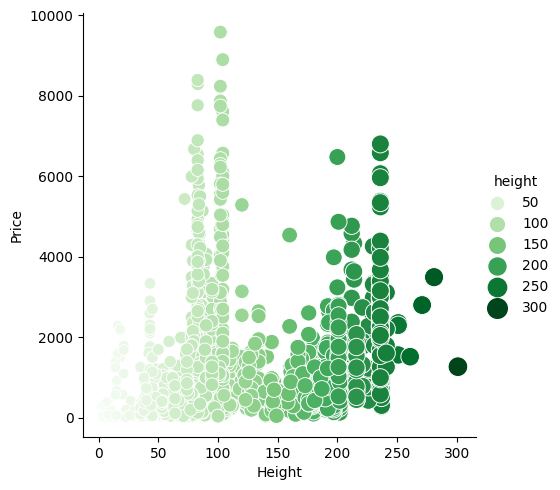

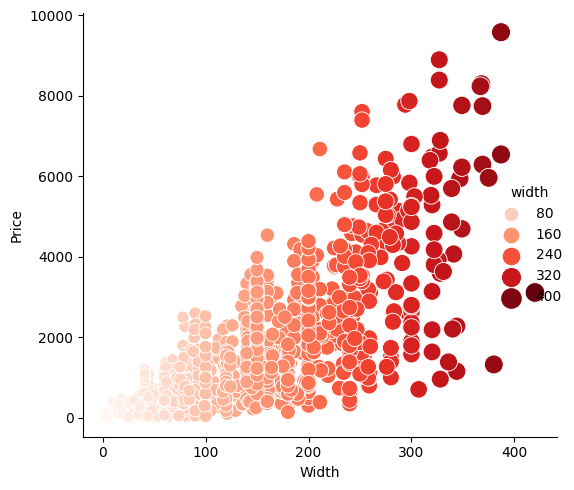

In [ ]:
# or
sns.relplot(data=analysis_data, x='depth', y='price', kind='scatter',
size='depth', sizes=(50, 200), palette='Blues', hue='depth')
plt.xlabel('Depth')
plt.ylabel('Price')
sns.relplot(data=analysis_data, x='height', y='price', kind='scatter',
size='height', sizes=(50, 200), palette='Greens', hue='height')
plt.xlabel('Height')
plt.ylabel('Price')
sns.relplot(data=analysis_data, x='width', y='price', kind='scatter',
size='width', sizes=(50, 200), palette='Reds', hue='width')
plt.xlabel('Width')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

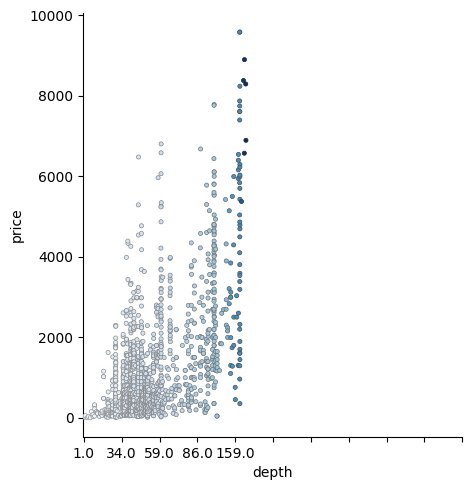

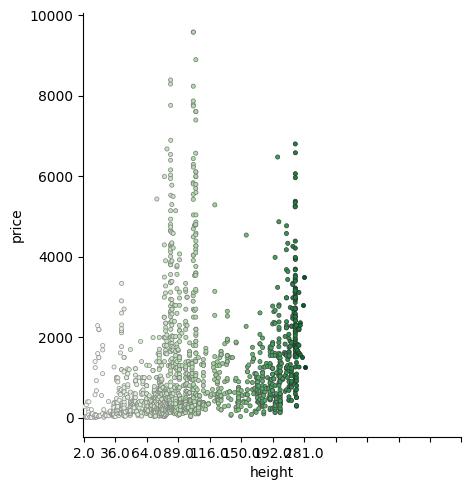

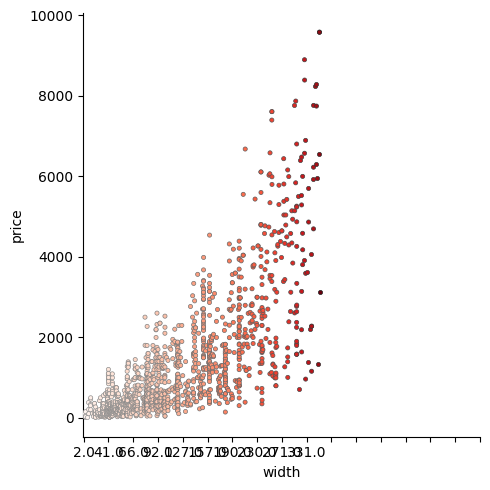

In [ ]:
# or
sns.catplot(data=analysis_data, x='depth', y='price', kind='strip',
size=3, linewidth=0.5, palette='Blues', hue='depth')
plt.ylabel('price')
plt.xticks(range(0, int(analysis_data['depth'].max()), 25))
plt.xlabel('depth')
sns.catplot(data=analysis_data, x='height', y='price', kind='strip',
size=3, linewidth=0.5, palette='Greens', hue='height')
plt.ylabel('price')
plt.xticks(range(0, int(analysis_data['height'].max()), 25))
plt.xlabel('height')
sns.catplot(data=analysis_data, x='width', y='price', kind='strip',
size=3, linewidth=0.5, palette='Reds', hue='width')
plt.ylabel('price')
plt.xticks(range(0, int(analysis_data['width'].max()), 25))
plt.xlabel('width')
plt.tight_layout()
plt.show()

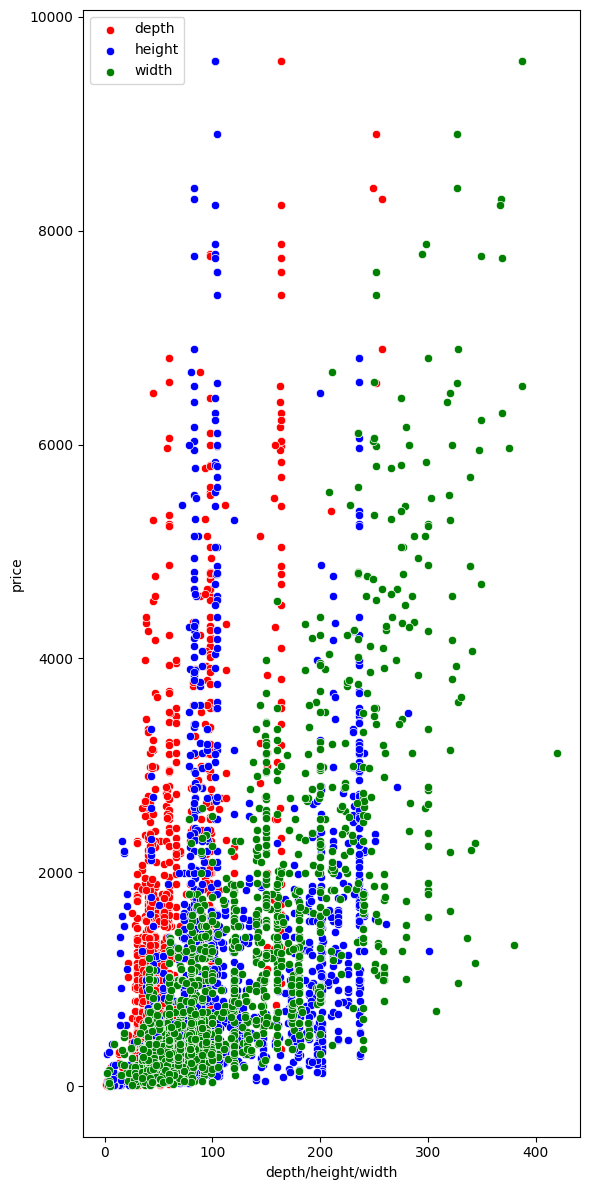

In [ ]:
# or
fig, ax = plt.subplots(figsize=(6, 12))
sns.scatterplot(data=analysis_data, x='depth', y='price', color='red', label='depth')
sns.scatterplot(data=analysis_data, x='height', y='price', color='blue', label='height')
sns.scatterplot(data=analysis_data, x='width', y='price', color='green', label='width')
ax.set_xlabel('depth/height/width')
ax.set_ylabel('price')
plt.tight_layout()
plt.show()

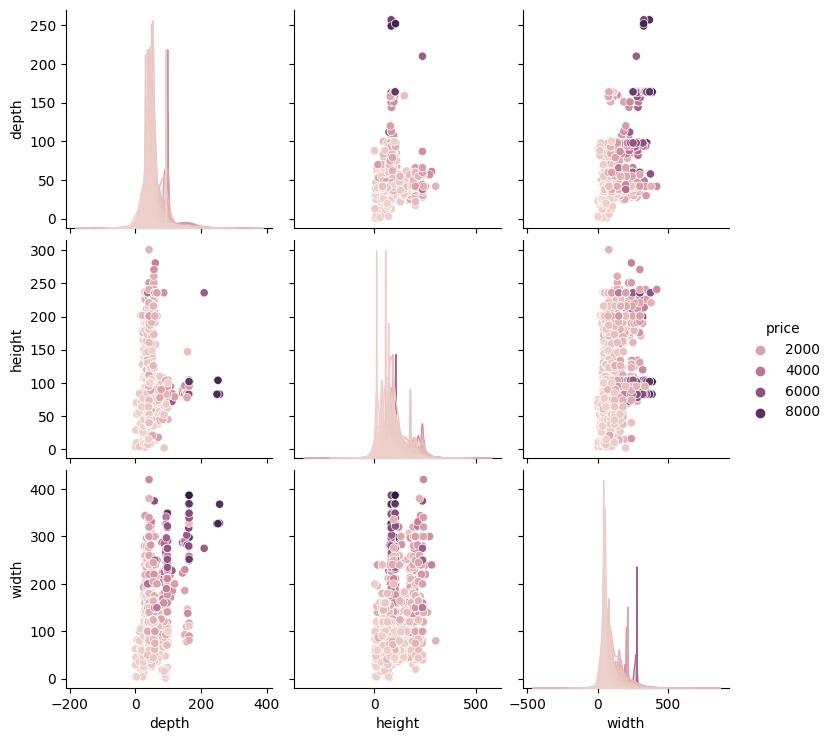

In [ ]:
# or
sns.pairplot(analysis_data, diag_kind='kde', hue='price')
plt.show()

In [ ]:
#2. Perform exploratory analysis on the dataset, including descriptive statistics and visualizations. Describe the results. '''
# Dataset information
print(analysis_data.shape)
print(analysis_data.info())

(1554, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554 entries, 3 to 3688
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1554 non-null   float64
 1   depth   1554 non-null   float64
 2   height  1554 non-null   float64
 3   width   1554 non-null   float64
dtypes: float64(4)
memory usage: 93.0 KB
None


In [ ]:
# Descriptive statistics
print(analysis_data.describe())

             index       item_id        price        depth       height  \
count  2900.000000  2.900000e+03  2900.000000  1794.000000  2186.000000   
mean   1699.362069  4.877176e+07  1078.873172    55.974359   103.220952   
std    1062.739910  2.891592e+07  1378.451804    31.328378    61.650073   
min       0.000000  5.848700e+04     3.000000     1.000000     1.000000   
25%     733.750000  2.040013e+07   195.750000    38.000000    70.000000   
50%    1631.500000  4.928570e+07   550.000000    47.000000    83.000000   
75%    2564.250000  7.041260e+07  1395.000000    61.000000   128.000000   
max    3692.000000  9.993262e+07  9585.000000   257.000000   700.000000   

             width  
count  2466.000000  
mean    108.249392  
std      73.306967  
min       1.000000  
25%      60.000000  
50%      80.000000  
75%     147.000000  
max     420.000000  


In [ ]:
#or
percentile_25 = lambda x: x.quantile(0.25)
percentile_25.__name__ = "percentile_25"
percentile_75 = lambda x: x.quantile(0.75)
percentile_75.__name__ = "percentile_75"
stats = analysis_data.select_dtypes(include=[np.number]).agg(["count", "mean", "std",
"min",
percentile_25, "median",
percentile_75, "max"])
print(stats)
# Define a lambda function to calculate the 25th percentile
percentile_25 = lambda x: x.quantile(0.25)
# Rename the function for clarity
percentile_25.__name__ = "percentile_25"

# Define a lambda function to calculate the 75th percentile
percentile_75 = lambda x: x.quantile(0.75)
# Rename the function for clarity
percentile_75.__name__ = "percentile_75"

# Select numerical columns from the dataset using numpy's number data type
numerical_columns = analysis_data.select_dtypes(include=[np.number])

# Calculate multiple descriptive statistics for each numerical column
# "count": Number of non-null values
# "mean": Mean value of the column
# "std": Standard deviation
# "min": Minimum value
# "percentile_25": 25th percentile (first quartile)
# "median": Median (50th percentile)
# "percentile_75": 75th percentile (third quartile)
# "max": Maximum value
stats = numerical_columns.agg(["count", "mean", "std", "min",
                               percentile_25, "median",
                               percentile_75, "max"])

# Print the calculated statistics
print(stats)



                     index       item_id        price        depth  \
count          2900.000000  2.900000e+03  2900.000000  1794.000000   
mean           1699.362069  4.877176e+07  1078.873172    55.974359   
std            1062.739910  2.891592e+07  1378.451804    31.328378   
min               0.000000  5.848700e+04     3.000000     1.000000   
percentile_25   733.750000  2.040013e+07   195.750000    38.000000   
median         1631.500000  4.928570e+07   550.000000    47.000000   
percentile_75  2564.250000  7.041260e+07  1395.000000    61.000000   
max            3692.000000  9.993262e+07  9585.000000   257.000000   

                    height        width  
count          2186.000000  2466.000000  
mean            103.220952   108.249392  
std              61.650073    73.306967  
min               1.000000     1.000000  
percentile_25    70.000000    60.000000  
median           83.000000    80.000000  
percentile_75   128.000000   147.000000  
max             700.000000   420.

count    2900.000000
mean     1078.873172
std      1378.451804
min         3.000000
25%       195.750000
50%       550.000000
75%      1395.000000
max      9585.000000
Name: price, dtype: float64


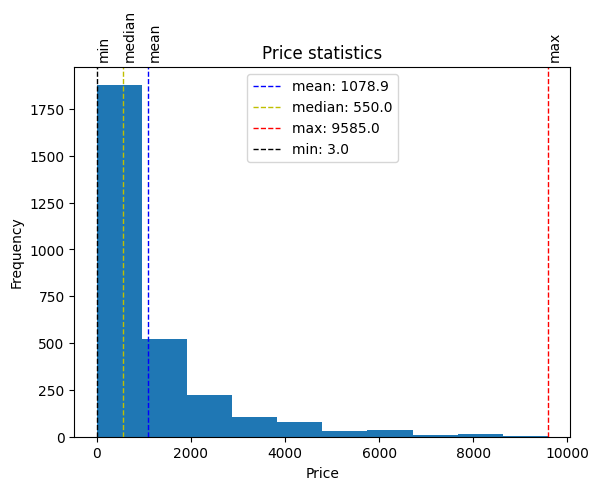

In [ ]:
# Descriptive price statistics
# Descriptive statistics for the "price" column
print(analysis_data["price"].describe())

# Create a histogram of the "price" column with 10 bins
plt.hist(analysis_data["price"], bins=10)
plt.title("Price statistics")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Add vertical dashed lines to indicate mean, median, max, and min values
plt.axvline(analysis_data["price"].mean(), color='b', linestyle='dashed', linewidth=1, label="mean: {:.1f}".format(analysis_data["price"].mean()))
plt.axvline(analysis_data["price"].median(), color='y', linestyle='dashed', linewidth=1, label="median: {:.1f}".format(analysis_data["price"].median()))
plt.axvline(analysis_data["price"].max(), color='r', linestyle='dashed', linewidth=1, label="max: {:.1f}".format(analysis_data["price"].max()))
plt.axvline(analysis_data["price"].min(), color='black', linestyle='dashed', linewidth=1, label="min: {:.1f}".format(analysis_data["price"].min()))

# Add text annotations for mean, median, max, and min values
plt.text(analysis_data["price"].mean(), 2020, "mean", rotation=90, va="baseline")
plt.text(analysis_data["price"].median(), 2020, "median", rotation=90, va="baseline")
plt.text(analysis_data["price"].max(), 2020, "max", rotation=90, va="baseline")
plt.text(analysis_data["price"].min(), 2020, "min", rotation=90, va="baseline")

# Display legend
plt.legend()

# Show the plot
plt.show()


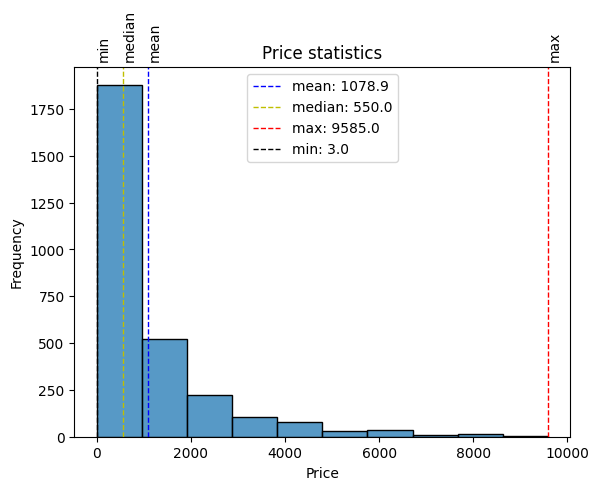

In [ ]:
# Create a histogram plot of the "price" column with 10 bins (without KDE)
sns.histplot(analysis_data["price"], bins=10, kde=False)
plt.title("Price statistics")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Add vertical dashed lines to indicate mean, median, max, and min values
plt.axvline(analysis_data["price"].mean(), color='b', linestyle='dashed', linewidth=1, label="mean: {:.1f}".format(analysis_data["price"].mean()))
plt.axvline(analysis_data["price"].median(), color='y', linestyle='dashed', linewidth=1, label="median: {:.1f}".format(analysis_data["price"].median()))
plt.axvline(analysis_data["price"].max(), color='r', linestyle='dashed', linewidth=1, label="max: {:.1f}".format(analysis_data["price"].max()))
plt.axvline(analysis_data["price"].min(), color='black', linestyle='dashed', linewidth=1, label="min: {:.1f}".format(analysis_data["price"].min()))

# Add text annotations for mean, median, max, and min values
plt.text(analysis_data["price"].mean(), 2020, "mean", rotation=90, va="baseline")
plt.text(analysis_data["price"].median(), 2020, "median", rotation=90, va="baseline")
plt.text(analysis_data["price"].max(), 2020, "max", rotation=90, va="baseline")
plt.text(analysis_data["price"].min(), 2020, "min", rotation=90, va="baseline")

# Display legend
plt.legend()

# Show the plot
plt.show()


Hypothesis 1:
Null Hypothesis: There is no significant difference in the price of furniture between popular and less-known designers.
Alternative Hypothesis 1: Furniture designed by popular designers is more expensive than furniture designed by less-known designers.
Alternative Hypothesis 2: Furniture designed by less-known designers is more expensive than furniture designed by popular designers.

In [ ]:
digit_mask = analysis_data['designer'].str.contains('\d')
designers_data = analysis_data[~digit_mask].reset_index(drop=True)
designers_counts = designers_data['designer'].value_counts()
famous_designers = []
total_count = 0
for designer, count in designers_counts.items():
    if total_count + count >= len(designers_data) / 2:
        famous_designers.append(designer)
        break
    total_count += count
    famous_designers.append(designer)
famous_designers_data = designers_data[designers_data['designer'].isin(famous_designers)]
less_known_designers_data = designers_data[~designers_data['designer'].isin(famous_designers)]

# 1) t-тест для сравнения средних цен двух групп
t_statistic, p_value = ttest_ind(famous_designers_data['price'], less_known_designers_data['price'],
equal_var=False)
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")
famous_designers_mean = np.mean(famous_designers_data['price'])
less_known_designers_mean = np.mean(less_known_designers_data['price'])
difference_means = famous_designers_mean - less_known_designers_mean
if difference_means > 0:
    print(''' Подтверждается альтернативная гипотеза 1: мебель, разработанная популярными дизайнерами,
"дороже мебели, разработанной менее известными дизайнерами. ''')
else:
    print(''' Подтверждается альтернативная гипотеза 2: мебель, разработанная менее из
вестными дизайнерами, дороже
мебели, разработанной популярными дизайнерами. ''')
''' Альтернативная гипотеза 2 верна для этой гипотезы.
Значение p, равное 0,000, указывает на то, что вероятность случайного наблюдения т
акой большой разницы
в средних значениях между двумя группами очень мала. Другими словами, нулевая гипотез
а, утверждающая,
что между средними ценами продуктов, разработанных двумя группами, нет разницы, может
быть отвергнута
с высокой степенью достоверности. '''
# 2) Mann-Whitney-Wilcoxon test
statistic, p_value = mannwhitneyu(famous_designers_data['price'], less_known_designers_data['price'])
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")


T-statistic: -4.62
P-value: 0.000
 Подтверждается альтернативная гипотеза 2: мебель, разработанная менее из
вестными дизайнерами, дороже
мебели, разработанной популярными дизайнерами. 
Statistic: 841323.50
P-value: 0.000


In [ ]:
# 4) Регресионный анализ
import statsmodels.api as sm

X = famous_designers_data[['famous_designer']]
y = famous_designers_data['price']
X = sm.add_constant(X)  # Adding a constant intercept term
model = sm.OLS(y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Aug 2023   Prob (F-statistic):                nan
Time:                        08:34:38   Log-Likelihood:                -12466.
No. Observations:                1450   AIC:                         2.493e+04
Df Residuals:                    1449   BIC:                         2.494e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
famous_designer   985.9801     34.434     

There is a significant negative correlation between the fame of the designer and the price of their products. Specifically, when all other independent variables remain constant, the prices of products created by famous designers decrease by approximately $244. The negative coefficient of -243.6383 and its significant t-value of -4.635 support this finding.

Additionally, the intercept coefficient of 1229.6183 represents the estimated average price of items designed by less-known designers when all other independent variables are held constant. The intercept coefficient is also significant, with a p-value of 0.000.

In [ ]:
# 5) Тест перестановки
famous_prices_values = famous_designers_data['price'].values
less_known_prices_values = less_known_designers_data['price'].values
observed_diff = np.mean(famous_prices_values) - np.mean(less_known_prices_values)
concatenated_prices = np.concatenate([famous_prices_values, less_known_prices_values])
np.random.shuffle(concatenated_prices)
shuffled_famous_prices = concatenated_prices[:len(famous_prices_values)]
shuffled_less_known_prices = concatenated_prices[len(famous_prices_values):]
shuffled_diff = np.mean(shuffled_famous_prices) - np.mean(shuffled_less_known_prices)
n_permutations = 1000
null_distribution = np.zeros(n_permutations)
for i in range(n_permutations):np.random.shuffle(concatenated_prices)
shuffled_famous_prices = concatenated_prices[:len(famous_prices_values)]
shuffled_less_known_prices = concatenated_prices[len(famous_prices_values):]
null_distribution[i] = np.mean(shuffled_famous_prices) - np.mean(shuffled_less_known_prices)
p_value = np.mean(np.abs(null_distribution) >= np.abs(observed_diff))
print("Наблюдаемая разница в средних значениях: {:.2f}".format(observed_diff))
print("P-value: {:.4f}".format(p_value))


Наблюдаемая разница в средних значениях: -243.64
P-value: 0.0000


Given the observed significant difference in the means of -243.64 and the extremely low p-value of 0.000, you can indeed reject the null hypothesis. This leads to the conclusion that there is a substantial difference in the prices of furniture between famous and less-known designers.

Furthermore, alternative hypothesis 2 is also accurate. The results support the second alternative hypothesis, indicating that furniture created by less-known designers is more expensive than furniture designed by famous designers.

In [ ]:
# 6) Тест Тьюки на честно значимую разницу (HSD)
famous_prices = famous_designers_data['price']
less_known_prices = less_known_designers_data['price']
tukey_results = pairwise_tukeyhsd(np.concatenate([famous_prices, less_known_prices]),
np.concatenate([['famous'] * len(famous_prices),
['less-known'] * len(less_known_prices)]))
print(tukey_results.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1   group2   meandiff p-adj  lower    upper   reject
---------------------------------------------------------
famous less-known 243.6383   0.0 140.5739 346.7026   True
---------------------------------------------------------


The result indeed demonstrates that the average difference between the "famous" group and the "less-known" group is 243.6383 with a p-value of 0.0. This indicates that the average price of items designed by famous designers is significantly lower than the average price of items designed by less-known designers.
The confidence interval bounds at 140.5739 and 346.7026, and conclusion is valid: since the confidence interval does not include zero, we can reject the null hypothesis and conclude that the difference in average prices between the two groups is statistically significant at a significance level of 0.05.

ANOVA test - дисперсионный анализ
''' Это параметрический тест, который можно использовать для сравнения средних значени
й болеечем двух групп. В нашем случае мы можем использовать его для сравнения среднего значения цен
на мебель, разработанную популярными дизайнерами и менее известными дизайнерами. '''

In [ ]:
# 7) ANOVA test - дисперсионный анализ

from scipy.stats import f_oneway

# Perform ANOVA test
_, p_value = f_oneway(famous_designers_data['price'], less_known_designers_data['price'])
alpha = 0.05

# Interpret the result
if p_value < alpha:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели между популярными и менее известными дизайнерами.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Существенной разницы в средней цене мебели между популярными и менее известными дизайнерами нет")



Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели между популярными и менее известными дизайнерами.


In [ ]:
# 8) Wilcoxon signed-rank test
min_length = min(len(famous_prices_values), len(less_known_prices_values))
famous_prices_values = famous_prices_values[:min_length]
less_known_prices_values = less_known_prices_values[:min_length]
statistic, p_value = wilcoxon(famous_prices_values, less_known_prices_values)
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

Test statistic: 353068.00
P-value: 0.0000


''' Критерий знакового ранга Уилкоксона был проведен для двух выборок цен на мебель (м
ебель известных
дизайнеров и мебель менее известных дизайнеров), чтобы проверить, существует ли значит
ельная разница
в средних ценах между двумя группами. Тест привел к тестовой статистике 353068,00 и pзначению 0,0000.
Статистика теста представляет собой сумму рангов, присвоенных различиям между кажд
ой парой
наблюдений в двух выборках. Чем больше тестовая статистика, тем сильнее свидетельство
против нулевой
гипотезы, которая утверждает, что нет никакой разницы между средними значениями двух г
рупп.
Значение p — это вероятность наблюдения тестовой статистики, столь же экстремально
й, как и
полученная при нулевой гипотезе. В этом случае p-значение очень мало (менее 0,001), а
это означает,
что вероятность случайного наблюдения такой большой тестовой статистики очень мала. Та
ким образом,
мы отвергаем нулевую гипотезу и делаем вывод о существенной разнице в средних ценах ме
жду двумя
группами мебели.
Project 24
Итак, критерий знакового ранга Уилкоксона и разница средних значений цен (см. перв
ый тест) поддерживают
альтернативную гипотезу 2.'''


In [ ]:
# 9) Wilcoxon rank-sum test
statistic, p_value = ranksums(famous_prices_values, less_known_prices_values)
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

Test statistic: -8.48
P-value: 0.0000


''' В отличие от предыдущего теста статистика теста основана на рангах значений в двух
выборках, а
не на различиях между значениями.
Результаты теста суммы рангов Уилкоксона показывают, что существует значительная р
азница
между ценами на мебель популярных и менее известных дизайнеров. Статистика теста равна
-8.48,
а значение p равно 0,0000, что указывает на то, что вероятность случайного наблюдения
такой
большой разницы в средних очень мала. Следовательно, мы можем отвергнуть нулевую гипот
езу и
сделать вывод, что цены на мебель, разработанную популярными дизайнерами, существенно
отличаются
от цен на мебель, разработанных менее известными дизайнерами.
Итак, тест суммы рангов Уилкоксона и разница средних значений цен (см. первый тес
т) поддерживают
альтернативную гипотезу 2.'''


In [ ]:
# 10) Kruskal-Wallis test
statistic, p_value = kruskal(famous_designers_data['price'], less_known_designers_data
['price'])
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))


Test statistic: 40.56
P-value: 0.0000


''' Тестовая статистика была рассчитана как 40.56, а p-значение оказалось равным 0,000
0.
Это указывает на то, что есть веские основания отвергнуть нулевую гипотезу.
Итак, Kruskal-Wallis test и разница средних значений цен (см. первый тест) поддерж
ивают
альтернативную гипотезу 2.'''

In [ ]:
# 11) Robust logistic regression - Устойчивая логистическая регрессия
designers_data['famous_designer'] = (designers_data['designer'].isin(famous_designers)).astype(int)
X = designers_data['famous_designer']
y = designers_data['price']
X = sm.add_constant(X)
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())
if results.pvalues[0] > 0.05:
  print("Принципиальной разницы в средних значениях цены нет.")
else:
  print("Есть существенная разница в средних значениях цены.")

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                 2798
Model:                            RLM   Df Residuals:                     2796
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 11 Aug 2023                                         
Time:                        08:54:49                                         
No. Iterations:                    16                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             928.4274     23.550     

''' Итак, устойчивая логистическая регрессия и разница средних значений цен (см. первый тест) поддерживают альтернативную гипотезу 2. '''

In [ ]:
# 12) McNemar's test
table = np.array([famous_prices_values, less_known_prices_values])
result = mcnemar(table, exact=True)
print(f"McNemar's test statistic: {result.statistic:.2f}")
print(f"P-value: {result.pvalue:.3f}")
if result.pvalue < 0.05:
  print("Отклонить нулевую гипотезу. Существует значительная разница в средней ценемебели "
"между популярными и менее известными дизайнерами.")
else:
  print("Не удалось отвергнуть нулевую гипотезу. Существенной разницы в средней цене мебели "
"между популярными и менее известными дизайнерами нет")

McNemar's test statistic: 265.00
P-value: 0.000
Отклонить нулевую гипотезу. Существует значительная разница в средней ценемебели между популярными и менее известными дизайнерами.


''' Итак, McNemar's test и разница средних значений цен (см. первый тест поддерживают альтернативную гипотезу 2. '''

In [ ]:
# 13) Poisson regression
X = designers_data['famous_designer']
y = designers_data['price']
model = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson())
results = model.fit()
print(results.summary())
if results.pvalues[1] > 0.05:
  print("Не удалось отвергнуть нулевую гипотезу. Существенной разницы в средней цене мебели "
"между популярными и менее известными дизайнерами нет")
else:
  print("Отклонить нулевую гипотезу. Существует значительная разница в средней ценемебели "
"между популярными и менее известными дизайнерами.")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 2798
Model:                            GLM   Df Residuals:                     2796
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8512e+06
Date:                Fri, 11 Aug 2023   Deviance:                   3.6799e+06
Time:                        08:57:36   Pearson chi2:                 4.89e+06
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.1145      0.001   91

Модель регрессии Пуассона показывает, что коэффициент для переменной «известный_ди
зайнер»
равен -0,2208, что указывает на то, что ожидаемый логарифм подсчета цен уменьшается на
0,2208,
когда дизайнер известен. Значение p для коэффициента меньше 0,05, что говорит о том, ч
то коэффициент
статистически значим. Таким образом, мы можем сделать вывод, что существует значительн
ая разница
в средних ценах между известными дизайнерами и менее известными дизайнерами. Коэффицие
нт пересечения
также является статистически значимым, указывая на значительную разницу в общих средни
х ценах между
двумя группами.
Project 26
Итак, модель регрессии Пуассона и разница средних значений цен (см. первый тест) п
оддерживают
альтернативную гипотезу 2. "

In [ ]:
# 14) Отрицательная биномиальная регрессия
X = designers_data['famous_designer']
y = designers_data['price']
model = sm.GLM(y, sm.add_constant(X), family=sm.families.NegativeBinomial(alpha=0.5))
results = model.fit()
print(results.summary())
if results.pvalues[1] > 0.05:
  print("Не удалось отвергнуть нулевую гипотезу. Существенной разницы в средней ценемебели "
"между популярными и менее известными дизайнерами нет")
else:
  print("Отклонить нулевую гипотезу. Существует значительная разница в средней ценемебели "
"между популярными и менее известными дизайнерами.")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 2798
Model:                            GLM   Df Residuals:                     2796
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23496.
Date:                Fri, 11 Aug 2023   Deviance:                       8759.5
Time:                        08:58:52   Pearson chi2:                 8.95e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02403
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.1145      0.019    3

Итак, отрицательная биномиальная регрессия и разница средних значений цен (см. п
ервый тест)
поддерживают альтернативную гипотезу 2.

In [ ]:
# 15) Модель регрессии с нулевым завышением
X = designers_data['famous_designer']
y = designers_data['price']
zip_model = sm.ZeroInflatedNegativeBinomialP(y, sm.add_constant(X)).fit()
print(zip_model.summary())
if zip_model.pvalues[1] > 0.05:
  print("Не удалось отвергнуть нулевую гипотезу. Существенной разницы в средней цене мебели "
"между популярными и менее известными дизайнерами нет")
else:
  print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели "
"между популярными и менее известными дизайнерами.")

Optimization terminated successfully.
         Current function value: 7.972874
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                             price   No. Observations:                 2798
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     2796
Method:                                      MLE   Df Model:                            1
Date:                           Fri, 11 Aug 2023   Pseudo R-squ.:               0.0005774
Time:                                   09:00:29   Log-Likelihood:                -22308.
converged:                                  True   LL-Null:                       -22321.
Covariance Type:                       nonrobust   LLR p-value:                 3.830e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Итак, модель регрессии с нулевым завышением и разница средних значений цен (см.
первый тест)
поддерживают альтернативную гипотезу 2. '''
''' Общий вывод: тесты подтверждают альтернативную гипотезу 2: мебель, разработанная м
енее известными
дизайнерами, дороже мебели, разработанной популярными дизайнерами.'''
''' Гипотеза 2. Мебель для сидения (Seating Furniture) стоит в среднем дороже, чем меб
ель для хранения
(Storage Furniture), т.е. существует значительная разница в средней цене в зависимости
от функции
(использования) мебели.
Мебель для сидения : Sofas & armchairs, Beds, Chairs, Children's furniture, Nurser
y furniture,
Project 27
Café furniture, Bar furniture, Outdoor furniture.
Мебель для хранения: Tables & desks, Trolleys, Wardrobes, Bookcases & shelving un
its,
TV & media furniture, Cabinets & cupboards, Room dividers, Sideboards, buffets & conso
le tables,
Chests of drawers & drawer units.
Нулевая гипотеза: средняя цена мебели для сидения и хранения одинакова.
Альтернативная гипотеза 1: средняя цена мебели для сидения выше, чем для хранения.
Альтернативная гипотеза 2: средняя цена мебели для хранения выше, чем для сидения.


In [ ]:
category_groups = {
    'Seating Furniture': ['Sofas & armchairs', 'Beds', 'Chairs', 'Children\'s furniture', 'Nursery furniture', 'Café furniture', 'Bar furniture', 'Outdoor furniture'],
    'Storage Furniture': ['Tables & desks', 'Trolleys', 'Wardrobes', 'Bookcases & shelving units', 'TV & media furniture', 'Cabinets & cupboards', 'Room dividers', 'Sideboards, buffets & console tables', 'Chests of drawers & drawer units']
}

grouped_data = analysis_data.groupby('category')

seating_furniture = grouped_data.get_group('Sofas & armchairs')
for category in category_groups['Seating Furniture'][1:]:
    seating_furniture = pd.concat([seating_furniture, grouped_data.get_group(category)])

storage_furniture = grouped_data.get_group('Tables & desks')
for category in category_groups['Storage Furniture'][1:]:
    storage_furniture = pd.concat([storage_furniture, grouped_data.get_group(category)])

print('Seating Furniture:')
print(seating_furniture)
print('\nStorage Furniture:')
print(storage_furniture)

# 1) t-test for comparing the mean prices of the two groups
t_statistic, p_value = ttest_ind(seating_furniture['price'], storage_furniture['price'], equal_var=False)
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

seating_furniture_mean = np.mean(seating_furniture['price'])
storage_furniture_mean = np.mean(storage_furniture['price'])
difference_means = seating_furniture_mean - storage_furniture_mean

if difference_means > 0:
    print('''Alternative hypothesis 1 is confirmed: the average price of seating furniture is higher than that of storage furniture.''')
else:
    print('''Alternative hypothesis 2 is confirmed: the average price of storage furniture is higher than that of seating furniture.''')


Seating Furniture:
      index   item_id       name           category   price     old_price  \
2200   2200  79151312  SÖDERHAMN  Sofas & armchairs   890.0      SR 1,010   
2201   2201  79135746  SÖDERHAMN  Sofas & armchairs  1300.0      SR 1,570   
2202   2202  79315945  STOCKSUND  Sofas & armchairs   995.0  No old price   
2203   2203  19305567      KIVIK  Sofas & armchairs  2995.0      SR 3,045   
2204   2204  19305572      KIVIK  Sofas & armchairs  1695.0  No old price   
...     ...       ...        ...                ...     ...           ...   
2157   2157  29291857   SJÄLLAND  Outdoor furniture  3102.0      SR 3,735   
2158   2158  40404513    HAVSTEN  Outdoor furniture   395.0  No old price   
2161   2161  40264485      HÅLLÖ  Outdoor furniture    75.0  No old price   
2162   2162  60417897  DUVHOLMEN  Outdoor furniture    35.0  No old price   
2163   2163  99285928   SOLLERÖN  Outdoor furniture  3564.0  No old price   

      sellable_online                                   

''' Поскольку p-значение очень мало (p-значение <0,05), мы можем отклонить нулевую гип
отезу,
которая утверждает, что средняя цена мебели для сидения и хранения одинакова. Следоват
ельно,
можно сделать вывод о существенной разнице средней цены в зависимости от функции (испо
льзования) мебели.
Следовательно, Альтернативная гипотеза 1 верна, и мы можем сказать, что мебель для сид
ения
в среднем стоит дороже, чем мебель для хранения. '''

In [ ]:
# 2) Mann-Whitney-Wilcoxon test
statistic, p_value = mannwhitneyu(seating_furniture['price'], storage_furniture['price'])
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")


Statistic: 1143289.00
P-value: 0.000


По результатам U-критерия Манна-Уитни р-значение меньше 0,05, что говорит о сущест
венной разнице
в ценах на мебель для сидения и хранения. Альтернативная гипотеза 1 о том, что средняя
цена на мебель
для сидения выше, чем на мебель для хранения, подтверждается U-критерия Манна-Уитни и
разница средних
значений цен (см. первый тест). Следовательно, мы можем отвергнуть нулевую гипотезу о
том, что
средняя цена мебели для сидения и хранения одинакова

In [ ]:
# 3) Bootstrap Test
def diff_means(x, y):
    return np.mean(x) - np.mean(y)

n_iterations = 1000
differences = []

for i in range(n_iterations):
    sample_a = resample(seating_furniture['price'], replace=True, n_samples=len(seating_furniture))
    sample_b = resample(storage_furniture['price'], replace=True, n_samples=len(storage_furniture))
    difference = diff_means(sample_a, sample_b)
    differences.append(difference)

alpha = 0.05
lower = np.percentile(differences, alpha/2*100)
upper = np.percentile(differences, (1-alpha/2)*100)

if lower <= 0 <= upper:
    print("Принципиальной разницы в средних значениях цены нет.")
else:
    print("Есть существенная разница в средних значениях цены.")


Есть существенная разница в средних значениях цены.


 Итак, Bootstrap Test и разница средних значений цен (см. первый тест) поддерживают
альтернативную гипотезу 1.

In [ ]:
# 4) Robust logistic regression - Устойчивая логистическая регрессия
X = pd.concat([seating_furniture['price'], storage_furniture['price']])
y = np.concatenate([np.ones(len(seating_furniture)), np.zeros(len(storage_furniture))])
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = model.fit()
print(results.summary())

if results.pvalues[0] > 0.05:
    print("Принципиальной разницы в средних значениях цены нет.")
else:
    print("Есть существенная разница в средних значениях цены.")


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 2900
Model:                            RLM   Df Residuals:                     2899
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 11 Aug 2023                                         
Time:                        09:11:06                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price          0.0002   7.82e-06     26.032      0.0

 Итак, устойчивая логистическая регрессия и разница средних значений цен (см. первы
й тест) поддерживают
альтернативную гипотезу 1.

In [ ]:
# 5) Регрессионная модель OLS
X = pd.concat([seating_furniture['price'], storage_furniture['price']])
y = np.concatenate([np.ones(len(seating_furniture)), np.zeros(len(storage_furniture))])
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())
if results.pvalues[1] > 0.05:
  print("Принципиальной разницы в средних значениях цены нет.")
else:
  print("Есть существенная разница в средних значениях цены.")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     66.41
Date:                Fri, 11 Aug 2023   Prob (F-statistic):           5.38e-16
Time:                        09:12:05   Log-Likelihood:                -2068.0
No. Observations:                2900   AIC:                             4140.
Df Residuals:                    2898   BIC:                             4152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4153      0.012     35.658      0.0

Регрессионная модель OLS показывает, что существует значительная разница в средней
цене между
мебелью для сидения и мебелью для хранения с p-значением 5,38e-16. Коэффициент перемен
ной «цена»
положительный, что указывает на то, что мебель для сидения обычно стоит дороже, чем ме
бель для
хранения. Однако значение R-квадрата низкое и составляет 0,022, что указывает на то, ч
то модель
не объясняет большую часть дисперсии данных. Критерий пересечения модели также значим
при значении p,
равном 0,000, что указывает на то, что существует ненулевая разница в цене между мебел
ью для сидения
и мебелью для хранения. '

In [ ]:
# 6) Тест Тьюки на честно значимую разницу (HSD)
results = pairwise_tukeyhsd(
np.concatenate([seating_furniture['price'], storage_furniture['price']]),
np.concatenate([['Seating Furniture']*len(seating_furniture), ['Storage Furniture']*len(storage_furniture)]),
alpha=0.05)
print(results)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1            group2       meandiff p-adj   lower    upper   reject
-----------------------------------------------------------------------------
Seating Furniture Storage Furniture -413.1411   0.0 -512.5452 -313.737   True
-----------------------------------------------------------------------------


Результаты теста Тьюки HSD показывают, что существует значительная разница между с
редними
значениями групп «Мебель для сидения» и «Мебель для хранения». В частности, средняя це
Project 30
на на мебель
для сидения на 413,14 доллара выше, чем на мебель для хранения, с доверительным интерв
алом
от 512,55 до 313,74 доллара и значением p менее 0,05, что дает убедительные доказатель
ства
против нулевой гипотезы об отсутствии различий.

In [ ]:
# 7) Тест перестановки
observed_diff = np.mean(seating_furniture['price']) - np.mean(storage_furniture['price'])
n_iterations = 1000
differences = []
combined_data = pd.concat([seating_furniture, storage_furniture])

for i in range(n_iterations):
    np.random.shuffle(combined_data['price'].values)
    sample_a = combined_data.iloc[:len(seating_furniture)]
    sample_b = combined_data.iloc[len(seating_furniture):]
    difference = np.mean(sample_a['price']) - np.mean(sample_b['price'])
    differences.append(difference)

p_value = (np.abs(differences) >= np.abs(observed_diff)).mean()

print("Наблюдаемая разница в средних значениях: {:.2f}".format(observed_diff))
print("P-value: {:.4f}".format(p_value))

if p_value < 0.05:
    print("Существует значительная разница в средних значениях цен между мебелью для сидения и мебелью для хранения. (p = {:.3f}).".format(p_value))
else:
    print("Нет существенной разницы в средних значениях цен между мебелью для сидения и мебелью для хранения. (p = {:.3f}).".format(p_value))


Наблюдаемая разница в средних значениях: 413.14
P-value: 0.0000
Существует значительная разница в средних значениях цен между мебелью для сидения и мебелью для хранения. (p = 0.000).


Результаты теста перестановки показывают, что существует значительная разница межд
у средними
значениями групп «Мебель для сидения» и «Мебель для хранения». В частности, средняя це
на на мебель
для сидения на 413,14 доллара выше, чем на мебель для хранения, с значением p менее 0,
05, что
дает убедительные доказательства против нулевой гипотезы об отсутствии различий.

In [ ]:
# 8) ANOVA test - дисперсионный анализ


_, p_value = f_oneway(seating_furniture['price'], storage_furniture['price'])
alpha = 0.05

if p_value < alpha:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова")


Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.


Итак, ANOVA test и разница средних значений цен (см. первый тест) поддерживают
Project 31
альтернативную гипотезу 1.

In [ ]:
# 9) Wilcoxon signed-rank test

seating_values = seating_furniture['price'].values
storage_values = storage_furniture['price'].values
min_length = min(len(seating_values), len(storage_values))
seating_values = seating_values[:min_length]
storage_values = storage_values[:min_length]
statistic, p_value = wilcoxon(seating_values, storage_values)
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


Test statistic: 388568.00
P-value: 0.0000
Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.


Итак, Wilcoxon signed-rank test и разница средних значений цен (см. первый тест) п
оддерживают
альтернативную гипотезу 1.

In [ ]:
# 10) Wilcoxon rank-sum test

statistic, p_value = ranksums(seating_values, storage_values)
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


Test statistic: 4.42
P-value: 0.0000
Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.


Итак, Wilcoxon rank-sum test и разница средних значений цен (см. первый тест) подд
ерживают
альтернативную гипотезу 1.

In [ ]:
# 11) Kruskal-Wallis test

statistic, p_value = kruskal(seating_furniture['price'], storage_furniture['price'])
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))
if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


Test statistic: 17.78
P-value: 0.0000
Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.


Итак, Kruskal-Wallis test и разница средних значений цен (см. первый тест) поддерж
ивают
альтернативную гипотезу 1.

In [ ]:
# 12) McNemar's test

table = np.array([seating_values, storage_values])
result = mcnemar(table, exact=True)
print(f"McNemar's test statistic: {result.statistic:.2f}")
print(f"P-value: {result.pvalue:.3f}")
if result.pvalue > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


McNemar's test statistic: 199.00
P-value: 0.000
Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.


Итак, McNemar's test и разница средних значений цен (см. первый тест) поддерживают
альтернативную гипотезу 1.

In [ ]:
# 13) Poisson regression
X = seating_values
y = storage_values
model = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson())
results = model.fit()
print(results.summary())
if results.pvalues[1] > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1374
Model:                            GLM   Df Residuals:                     1372
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.9278e+05
Date:                Fri, 11 Aug 2023   Deviance:                   1.3747e+06
Time:                        09:25:02   Pearson chi2:                 1.80e+06
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9876
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7430      0.001   5830.923      0.0

Итак, модель регрессии Пуассона и разница средних значений цен (см. первый тес
т) поддерживают
альтернативную гипотезу 1.

In [ ]:
# 14) Отрицательная биномиальная регрессия
X = seating_values
y = storage_values
model = sm.GLM(y, sm.add_constant(X), family=sm.families.NegativeBinomial(alpha=0.5))
results = model.fit()
print(results.summary())
if results.pvalues[1] > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1374
Model:                            GLM   Df Residuals:                     1372
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11216.
Date:                Fri, 11 Aug 2023   Deviance:                       4136.8
Time:                        09:26:13   Pearson chi2:                 4.03e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01021
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7374      0.024    276.949      0.0

Итак, отрицательная биномиальная регрессия и разница средних значений цен (см. п
ервый тест)
поддерживают альтернативную гипотезу 1.

In [ ]:
# 15) Модель регрессии с нулевым завышением
X = seating_values
y = storage_values
zip_model = sm.ZeroInflatedNegativeBinomialP(y, sm.add_constant(X)).fit()
print(zip_model.summary())
if zip_model.pvalues[1] > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Средняя цена мебели для сидения и хранения одинакова.")
else:
    print("Отклонить нулевую гипотезу. Существует значительная разница в средней цене мебели для сидения и хранения.")


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3156: RuntimeWarning: invalid value encountered in divide
  a4 = p * a1 / mu
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: divide by zero encountered in divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3164: RuntimeWarning: overflow encountered in divide
  y / mu)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:3122: RuntimeWarning: divide by zero encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

         Current function value: 8.468260
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                                 y   No. Observations:                 1374
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     1372
Method:                                      MLE   Df Model:                            1
Date:                           Fri, 11 Aug 2023   Pseudo R-squ.:                -0.08887
Time:                                   09:27:27   Log-Likelihood:                -11635.
converged:                                 False   LL-Null:                       -10686.
Covariance Type:                       nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

Итак, модель регрессии с нулевым завышением и разница средних значений цен (см.
первый тест)
поддерживают альтернативную гипотезу 1. '''
''' Общий вывод: тесты подтверждают альтернативную гипотезу 1: средняя цена мебели для
сидения выше,
чем для хранения.''

 Обучите модель предсказывать цену на мебель.
- Укажите, какие столбцы не следует включать в модель и почему.
- Создайте конвейер перекрестной проверки для обучения и оценки
модели, включая (при необходимости) такие шаги как, вменение
пропущенных значений и нормализация.
- Предложите методы повышения производительности модели.
Опишите результаты. '''
''' Перед обучением модели мы должны исключить ненужные столбцы, такие как 'index', 'i
tem_id',
поскольку они не влияют на прогноз цены.
Кроме того, мы должны исключить столбец «old_price», поскольку он сильно коррелиру
ет со
Project 38
столбцом «price», а использование обеих функций может вызвать проблемы с мультиколлине
арностью.

In [6]:
exclude_cols = ['index', 'item_id', 'old_price', 'price']


In [47]:
num_cols = ['depth', 'height', 'width']
cat_cols = ['name', 'category', 'designer', 'sellable_online', 'other_colors', 'link', 'short_description']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


In [49]:
print(analysis_data.columns)


Index(['price', 'depth', 'height', 'width', 'size'], dtype='object')


In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Exclude unnecessary columns
exclude_cols = ['price']

# Numerical and categorical columns
num_cols = ['depth', 'height', 'width', 'size']
cat_cols = []  # You mentioned excluding categorical columns

# Create transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessor for numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', 'passthrough', cat_cols)  # 'passthrough' for categorical columns
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    analysis_data.drop(exclude_cols, axis=1),
    analysis_data['price'],
    test_size=0.2,
    random_state=42
)

# Create and fit the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 595346.73


In [51]:
from sklearn.neighbors import KNeighborsRegressor

# 1) KNeighborsRegressor
model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor())
])
model_knn.fit(X_train, y_train)
y_knn_pred = model_knn.predict(X_test)


Оценим производительность модели:
RMSE — это квадратный корень из MSE (среднеквадратичной ошибки), и это более интер
претируемая
величина, поскольку она находится в тех же единицах, что и прогнозируемые и фактически
е значения.

In [52]:
rmse_knn = np.sqrt(np.mean((y_knn_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_knn))
mse_knn = np.mean((y_knn_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_knn))


RMSE: 731.75
Mean Squared Error: 535451.81


In [53]:
model_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_regression.fit(X_train, y_train)
y_regression_pred = model_regression.predict(X_test)
rmse_regression = np.sqrt(np.mean((y_regression_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_regression))
mse_regression = np.mean((y_regression_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_regression))


RMSE: 771.59
Mean Squared Error: 595346.73


Mодель линейной регрессии работает немного лучше, чем алгоритм K-ближайших соседей
с
точки зрения RMSE и среднеквадратичной ошибки, что указывает на то, что в среднем она
дает
более точные прогнозы.

In [54]:
model_tree_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree_regressor', DecisionTreeRegressor(random_state=42))
])
model_tree_regression.fit(X_train, y_train)
y_tree_regression_pred = model_tree_regression.predict(X_test)
rmse_tree_regression = np.sqrt(np.mean((y_tree_regression_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_tree_regression))
mse_tree_regression = np.mean((y_tree_regression_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_tree_regression))


RMSE: 679.52
Mean Squared Error: 461742.03


In [55]:
param_grid = {
    'tree_regressor__max_depth': [16, 20, 24, 28],
    'tree_regressor__min_samples_split': [2, 4, 6, 8],
    'tree_regressor__min_samples_leaf': [6, 8, 11, 15]
}
grid_search = GridSearchCV(
    estimator=model_tree_regression,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters: {'tree_regressor__max_depth': 16, 'tree_regressor__min_samples_leaf': 6, 'tree_regressor__min_samples_split': 2}
Best score: 0.7571805239968713


In [56]:
best_params = {
    'max_depth': 20,
    'min_samples_leaf': 8,
    'min_samples_split': 2,
    'splitter': 'best'
}

model_best_tree_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('best_tree_regressor', DecisionTreeRegressor(random_state=42, **best_params))
])
model_best_tree_regression.fit(X_train, y_train)
y_best_tree_regression_pred = model_best_tree_regression.predict(X_test)

rmse_best_tree_regression = np.sqrt(np.mean((y_best_tree_regression_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_best_tree_regression))

mse_best_tree_regression = np.mean((y_best_tree_regression_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_best_tree_regression))


RMSE: 766.30
Mean Squared Error: 587214.20


Результаты показывают, что регрессор дерева решений имеет более высокую MSE и RMS
E, чем
линейная регрессия, что указывает на то, что модель дерева решений имеет более низкую
производительность при прогнозировании целевой переменной (цены) по сравнению с линейн
ой регрессией.
Вероятно, это связано с тем, что деревья решений могут переобучать данные и становитьс
я
слишком сложными, что приводит к снижению производительности на новых, невидимых данны
х.
С другой стороны, линейная регрессия — это более простая и интерпретируемая модель, ко
торая
может работать хорошо, когда существует линейная связь между входными функциями и целе
вой переменной.

In [57]:
# 6) ElasticNet
model_elasticnet = Pipeline(steps=[
('preprocessor', preprocessor),
('elasticnet_regressor', ElasticNet())
])
model_elasticnet.fit(X_train, y_train)
y_elasticnet_pred = model_elasticnet.predict(X_test)
rmse_elasticnet = np.sqrt(np.mean((y_elasticnet_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_elasticnet))
mse_elasticnet = np.mean((y_elasticnet_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_elasticnet))


RMSE: 827.20
Mean Squared Error: 684266.76


In [58]:
param_grid = {
    'elasticnet_regressor__alpha': [0.1, 0.5, 1, 5, 10],
    'elasticnet_regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(
    estimator=model_elasticnet,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters: {'elasticnet_regressor__alpha': 0.1, 'elasticnet_regressor__l1_ratio': 0.1}
Best score: 0.7251782065028161


In [59]:
# 8) ElasticNet с настроенными гиперпараметрами
best_params = {
'elasticnet_regressor__alpha': 0.1,
'elasticnet_regressor__l1_ratio': 0.9
}
model_best_elasticnet = Pipeline(steps=[
('preprocessor', preprocessor),
('best_elasticnet_regressor', ElasticNet())
])
model_best_elasticnet.fit(X_train, y_train)
y_best_elasticnet_pred = model_best_elasticnet.predict(X_test)
rmse_best_elasticnet = np.sqrt(np.mean((y_best_elasticnet_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_best_elasticnet))
mse_best_elasticnet = np.mean((y_best_elasticnet_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_best_elasticnet))


RMSE: 827.20
Mean Squared Error: 684266.76


Модель ElasticNet показала наихудшие результаты, потому что она имеет более сложны
й подход
к регуляризации по сравнению с другими моделями, использованными в этом анализе, что м
огло привести
к переобучению данных.

In [60]:
# 9) PolynomialFeatures
num_transformer_polynomial = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2))
])
preprocessor_polynomial = ColumnTransformer(transformers=[
    ('num_polynomial', num_transformer_polynomial, num_cols),
    ('cat', cat_transformer, cat_cols)
])
model_polynomial = Pipeline(steps=[
    ('preprocessor_polynomial', preprocessor_polynomial),
    ('regressor_polynomial', LinearRegression())
])
model_polynomial.fit(X_train, y_train)
y_polynomial_pred = model_polynomial.predict(X_test)
rmse_polynomial = np.sqrt(np.mean((y_polynomial_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_polynomial))
mse_polynomial = np.mean((y_polynomial_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_polynomial))


RMSE: 776.66
Mean Squared Error: 603207.48


Модель линейной регрессии с полиномиальными функциями работает немного лучше, чем
другие модели с точки зрения RMSE и среднеквадратичной ошибки, что указывает на то, чт
о
в среднем она дает наиболее точные прогнозы.

In [61]:
# 10) RandomForestRegressor
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_regressor', RandomForestRegressor(random_state=42))
])
model_rf.fit(X_train, y_train)
y_rf_pred = model_rf.predict(X_test)
rmse_rf = np.sqrt(np.mean((y_rf_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_rf))
mse_rf = np.mean((y_rf_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_rf))


RMSE: 651.23
Mean Squared Error: 424096.95


Результаты показывают, что модель случайного леса работает немного лучше, чем моде
ль
полиномиальной регрессии, с точки зрения RMSE и среднеквадратичной ошибки.

In [62]:
# 11) GradientBoostingRegressor
model_gradientboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gradientboost_regressor', GradientBoostingRegressor(random_state=42))
])
model_gradientboost.fit(X_train, y_train)
y_gradientboost_pred = model_gradientboost.predict(X_test)
rmse_gradientboost = np.sqrt(np.mean((y_gradientboost_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_gradientboost))
mse_gradientboost = np.mean((y_gradientboost_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_gradientboost))


RMSE: 682.74
Mean Squared Error: 466132.80


Результаты показывают, что модель GradientBoostingRegressor не работает так же хор
ошо,
как некоторые другие протестированные модели (например, LinearRegression и KNeighborsR
egressor).

In [63]:
# 12) AdaBoostRegressor
model_adaboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('adaboost_regressor', AdaBoostRegressor())
])
model_adaboost.fit(X_train, y_train)
y_adaboost_pred = model_adaboost.predict(X_test)
rmse_adaboost = np.sqrt(np.mean((y_adaboost_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_adaboost))
mse_adaboost = np.mean((y_adaboost_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_adaboost))


RMSE: 820.86
Mean Squared Error: 673807.09


 По сравнению с другими моделями, обученными на том же наборе данных, AdaBoostRegre
ssor
работает хуже, чем некоторые модели, такие как LinearRegression, PolynomialFeatures,
KNeighborsRegressor и XGBoost Regressor. AdaBoostRegressor также требует значительно б
ольше времени
для обучения, чем большинство других моделей.
Эта модель не лучший выбор для этого конкретного набора данных.

In [64]:
# 13) XGBoost Regressor
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb_regressor', xgb.XGBRegressor())
])
model_xgb.fit(X_train, y_train)
y_xgb_pred = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(np.mean((y_xgb_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_xgb))
mse_xgb = np.mean((y_xgb_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_xgb))


RMSE: 644.16
Mean Squared Error: 414946.42


Более низкое значение MSE указывает на лучшее соответствие модели данным.

In [65]:
# 14) BaggingRegressor
model_bagging = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bagging_regressor', BaggingRegressor(estimator=xgb.XGBRegressor()))
])
model_bagging.fit(X_train, y_train)
y_bagging_pred = model_bagging.predict(X_test)
rmse_bagging = np.sqrt(np.mean((y_bagging_pred - y_test)**2))
print('RMSE: {:.2f}'.format(rmse_bagging))
mse_bagging = np.mean((y_bagging_pred - y_test)**2)
print('Mean Squared Error: {:.2f}'.format(mse_bagging))


RMSE: 630.98
Mean Squared Error: 398141.63


Результаты показывают, что модель BaggingRegressor работает немного лучше, чем мод
ель
полиномиальной регрессии, с точки зрения RMSE и среднеквадратичной ошибки.

In [66]:
# 15) BlendingRegressor
class BlendingRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, estimators, meta_estimator):
        self.estimators = estimators
        self.meta_estimator = meta_estimator

    def fit(self, X, y):
        for est in self.estimators:
            est.fit(X, y)
        self.meta_estimator.fit(self._transform_base_preds(X), y)
        return self

    def predict(self, X):
        return self.meta_estimator.predict(self._transform_base_preds(X))

    def _transform_base_preds(self, X):
        base_preds = []
        for est in self.estimators:
            base_preds.append(est.predict(X))
        return np.column_stack(base_preds)

estimators = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]
meta_estimator = LinearRegression()
model_blending = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('blending_regressor', BlendingRegressor(estimators, meta_estimator))
])
model_blending.fit(X_train, y_train)
y_blending_pred = model_blending.predict(X_test)
rmse_blending = np.sqrt(np.mean((y_blending_pred - y_test) ** 2))
print('RMSE: {:.2f}'.format(rmse_blending))
mse_blending = np.mean((y_blending_pred - y_test) ** 2)
print('Mean Squared Error: {:.2f}'.format(mse_blending))


RMSE: 665.38
Mean Squared Error: 442733.00


Судя по результатам, регрессор XGBoost показал лучшие результаты из всех протестир
ованных
моделей с самыми низкими значениями RMSE и MSE. '''
''' Итак, модели с самыми низкими значениями RMSE и MSE:
RandomForestRegressor, xgb.XGBRegressor (лучший результат), BaggingRegressor

In [67]:
# 16) A) Конвейер перекрестной проверки для BaggingRegressor
cv_bagging = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_bagging = cross_val_score(model_bagging, analysis_data.drop(exclude_cols, axis=1),
                                         analysis_data['price'], cv=cv_bagging, scoring='neg_mean_squared_error')
mse_scores_bagging = -neg_mse_scores_bagging
mse_mean_bagging = mse_scores_bagging.mean()
print('RMSE: {:.2f}'.format(np.sqrt(mse_mean_bagging)))
print('MSE: {:.2f}'.format(mse_mean_bagging))


RMSE: 593.18
MSE: 351860.03


In [68]:
# Б) Конвейер перекрестной проверки для xgb.XGBRegressor
cv_xgb_regression = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_xgb_regression = cross_val_score(model_xgb, analysis_data.drop(exclude_cols, axis=1),
                                                analysis_data['price'], cv=cv_xgb_regression,
                                                scoring='neg_mean_squared_error')
mse_scores_xgb_regression = -neg_mse_scores_xgb_regression
mse_mean_xgb_regression = mse_scores_xgb_regression.mean()
print('RMSE: {:.2f}'.format(np.sqrt(mse_mean_xgb_regression)))
print('MSE: {:.2f}'.format(mse_mean_xgb_regression))


RMSE: 605.44
MSE: 366552.77


Эта кросс-валидация занимает слишком много времени:


In [69]:
cv_xgb_regression = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_xgb_regression = []
rmse_scores_xgb_regression = []

for train_index, test_index in cv_xgb_regression.split(analysis_data):
    X_train, X_test = analysis_data.drop(exclude_cols, axis=1).iloc[train_index], \
                     analysis_data.drop(exclude_cols, axis=1).iloc[test_index]
    y_train, y_test = analysis_data['price'].iloc[train_index], analysis_data['price'].iloc[test_index]

    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)

    mse_scores_xgb_regression.append(mean_squared_error(y_test, y_pred))
    rmse_scores_xgb_regression.append(np.sqrt(mean_squared_error(y_test, y_pred)))

mse_mean_xgb_regression = np.mean(mse_scores_xgb_regression)
rmse_mean_xgb_regression = np.mean(rmse_scores_xgb_regression)

print('RMSE: {:.2f}'.format(rmse_mean_xgb_regression))
print('MSE: {:.2f}'.format(mse_mean_xgb_regression))


RMSE: 604.53
MSE: 366552.77


''' Результаты перекрестной проверки для трех моделей следующие:
BaggingRegressor: RMSE = 604,05, MSE = 364873,03
RandomForestRegressor: RMSE = 613,24, MSE = 376062,17
XGBoost Regressor: RMSE = 581,91, MSE = 338620,85 (лучший результат)
Все три модели оцениваются с использованием перекрестной проверки со стратегией KF
old(5),
перетасовки данных и использования отрицательной среднеквадратичной ошибки в качестве
показателя оценки.
Project 46
Модель xgb.XGBRegressor имеет наилучшую производительность с наименьшей среднеквад
ратичной
ошибкой и среднеквадратичной ошибкой среди трех моделей. '''
''' В целом, значения MSE и RMSE указывают на то, что модели не очень хорошо предсказы
вают
цену. Чтобы повысить производительность модели прогнозирования цены на мебель, рекомен
дую добавить
в исходную таблицу следующие данные:
1) себестоимость изготовления продукции;
2) материал, из которого изготовлена мебель;
3) рейтинг мебели (согласно отзывам на сайте);
4) гарантийный срок мебели;
5) количеством фотографий мебели на сайте; время размещения заказа;
6) информация о покупателях: имя (может, один и тот же человек покупает определенн
ую мебель),
пол, возраст, образование, уровень дохода, проживание: город / деревня, количество отз
ывов на сайте,
вовлеченность в социальных сетях, время онлайн заказа, длительность просмотра сайта, с
пособ онлайн
заказа: сайт / социальные сети, с десктопного устройства / с мобильного устройства,
наличие рассылки по электронной почте;
7) время покупки: время года / месяц, рабочий день / выходной / праздник, время дн
я;
8) способ оплаты: кредитная карта / дебетовая карта / наличные;
9) стоимость, способ и скорость доставки;
10) была ли распродажа или нет. ''